In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(patchwork)))
suppressPackageStartupMessages(suppressWarnings(library(cowplot)))
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML)))
suppressPackageStartupMessages(suppressWarnings(library(pheatmap)))
suppressPackageStartupMessages(suppressWarnings(library(lattice)))
suppressPackageStartupMessages(suppressWarnings(library("RColorBrewer")))
suppressPackageStartupMessages(suppressWarnings(library(gplots)))
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap)))
suppressPackageStartupMessages(suppressWarnings(library(ggplotify)))
suppressPackageStartupMessages(suppressWarnings(library("arrow")))
suppressPackageStartupMessages(suppressWarnings(library(scales)))
suppressPackageStartupMessages(suppressWarnings(library(circlize)))
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) 

# insall ggmagnify from hughjonesd's universe
install.packages("ggmagnify", repos = c("https://hughjonesd.r-universe.dev", 
                 "https://cloud.r-project.org"))
suppressPackageStartupMessages(suppressWarnings(library(ggmagnify)))
source("../../utils/figure_themes.r")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## Generate each individual plot priot to combining them in a single figure (pathwork)

In [2]:
# Load in the treatment list
toml_path <- file.path("..","..","..","1.Exploratory_Data_Analysis/utils/params.toml")
p <- parseTOML(toml_path)
# get the list that is in the toml file under the key "treatments"
# define that list as a variable called list_of_treatments and print the list to verify
list_of_treatments <- c(p$list_of_treatments$treatments)
list_of_treatments


[1] "DMSO_0.100_%_DMSO_0.025_%"                           
 [2] "Thapsigargin_1.000_uM_DMSO_0.025_%"                  
 [3] "Thapsigargin_10.000_uM_DMSO_0.025_%"                 
 [4] "H2O2_100.000_uM_DMSO_0.025_%"                        
 [5] "H2O2_100.000_nM_DMSO_0.025_%"                        
 [6] "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"              
 [7] "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"              
 [8] "LPS_0.010_ug_per_ml_DMSO_0.025_%"                    
 [9] "LPS_0.100_ug_per_ml_DMSO_0.025_%"                    
[10] "LPS_1.000_ug_per_ml_DMSO_0.025_%"                    
[11] "LPS_10.000_ug_per_ml_DMSO_0.025_%"                   
[12] "LPS_100.000_ug_per_ml_DMSO_0.025_%"                  
[13] "LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%" 
[14] "LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%" 
[15] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%"

In [3]:
# Figure 2A

# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# filter out the treatments that are not in the list
cytokine_values <- cytokine_values[cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]

# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)

control_ground_truth_list

[1] "DMSO_0.100_%_DMSO_0.025_%"                                   
 [2] "DMSO_0.100_%_DMSO_1.000_%"                                   
 [3] "DMSO_0.100_%_Z-VAD-FMK_100.000_uM"                           
 [4] "DMSO_0.100_%_Z-VAD-FMK_30.000_uM"                            
 [5] "Disulfiram_0.100_uM_DMSO_0.025_%"                            
 [6] "Disulfiram_1.000_uM_DMSO_0.025_%"                            
 [7] "Disulfiram_2.500_uM_DMSO_0.025_%"                            
 [8] "H2O2_100.000_nM_DMSO_0.025_%"                                
 [9] "H2O2_100.000_uM_DMSO_0.025_%"                                
[10] "H2O2_100.000_uM_Disulfiram_1.000_uM"                         
[11] "H2O2_100.000_uM_Z-VAD-FMK_100.000_uM"                        
[12] "LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM"                   
[13] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM"
[14] "Media"                                                       
[15] "Topotecan_10.000_nM_DMSO_0.025_%"                            
[16] "Topotecan_20.000_nM_DMSO_0.025_%"                            
[17] "Topotecan_5.000_nM_DMSO_0.025_%"

In [4]:
# convert to a dataframe
cytokine_values <- as.data.frame(cytokine_values)
head(cytokine_values,2)

# make a new column that is the treatment group based on the ground truth data
cytokine_values$group <- ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cytokine_values$group <- factor(cytokine_values$group, levels = c("Control","Apoptosis", "Pyroptosis"))

,plate_name,plate_barcode,position_x,cell_type,incubation inducer,inhibitor,inhibitor_concentration_value,inhibitor_concentration_unit,inhibitor_concentration,inducer1,⋯,VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],Treatment,Dose,oneb_Treatment_Dose_Inhibitor_Dose,twob_Treatment_Dose_Inhibitor_Dose,threeb_Treatment_Dose_Inhibitor_Dose,fourb_Treatment_Dose_Inhibitor_Dose
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,70117_20230210MM1_P1,430420,B06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.2588339,0.2383579,0.5242758,0.2506705,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030
2,70117_20230210MM1_P1,430420,C06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.3811698,0.1686448,0.4550923,0.2287523,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030


In [5]:
# mutate the names of each treatment
cytokine_values <- cytokine_values %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))


In [6]:
treatment_order <- c(
    'DMSO 0.1%',
    'Flagellin 0.1 ug/ml',
    'Flagellin 1.0 ug/ml',
    'LPS 0.01 ug/ml',
    'LPS 0.1 ug/ml',
    'LPS 1.0 ug/ml',
    'LPS 10.0 ug/ml',
    'LPS 100.0 ug/ml',
    'LPS 1.0 ug/ml + Nigericin 1.0 uM', 
    'LPS 1.0 ug/ml + Nigericin 3.0 uM',
    'LPS 1.0 ug/ml + Nigericin 10.0 uM',
    'H2O2 100.0 nM',
    'H2O2 100.0 uM',
    'Thapsigargin 1.0 uM',
    'Thapsigargin 10.0 uM'
)
cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose <- factor(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose, levels = treatment_order)

# create grouping of treatment and group
cytokine_values$group_treatment <- paste(cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose, cytokine_values$group,  sep = ", ")
# make the group_treatment column a factor
cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose <- factor(
    cytokine_values$oneb_Treatment_Dose_Inhibitor_Dose, 
    levels = c(
        'DMSO 0.1%',
        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',
        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',
        'H2O2 100.0 nM',
        'H2O2 100.0 uM',
        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM'
    )
)


In [7]:
head(cytokine_values,2)

,plate_name,plate_barcode,position_x,cell_type,incubation inducer,inhibitor,inhibitor_concentration_value,inhibitor_concentration_unit,inhibitor_concentration,inducer1,⋯,WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],Treatment,Dose,oneb_Treatment_Dose_Inhibitor_Dose,twob_Treatment_Dose_Inhibitor_Dose,threeb_Treatment_Dose_Inhibitor_Dose,fourb_Treatment_Dose_Inhibitor_Dose,group,group_treatment
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>
1,70117_20230210MM1_P1,430420,B06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.5242758,0.2506705,DMSO,0.100_%,DMSO 0.1%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control,"DMSO 0.1%, Control"
2,70117_20230210MM1_P1,430420,C06,PBMC,6_h,DMSO,0.025,%,0.030,DMSO,⋯,0.4550923,0.2287523,DMSO,0.100_%,DMSO 0.1%,DMSO_DMSO_0.100_%,DMSO__0.100_%__DMSO_0.030,DMSO__0.100_%__DMSO__0.030,Control,"DMSO 0.1%, Control"


In [8]:
# set plot size
width = 1520
cytokine_scatter_plot <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = `IL-1 beta [NSU]`,
            y = `CCL24 [NSU]`,
            color = oneb_Treatment_Dose_Inhibitor_Dose,
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + xlab("IL-1 beta abundance")
    + ylab("CCL24 abundance")
    + xlim(-0.1, 1)
    + ylim(-0.1, 1)
    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
    + theme(axis.text.x = element_text( vjust = 0.5, hjust=1))
    + theme(
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
)


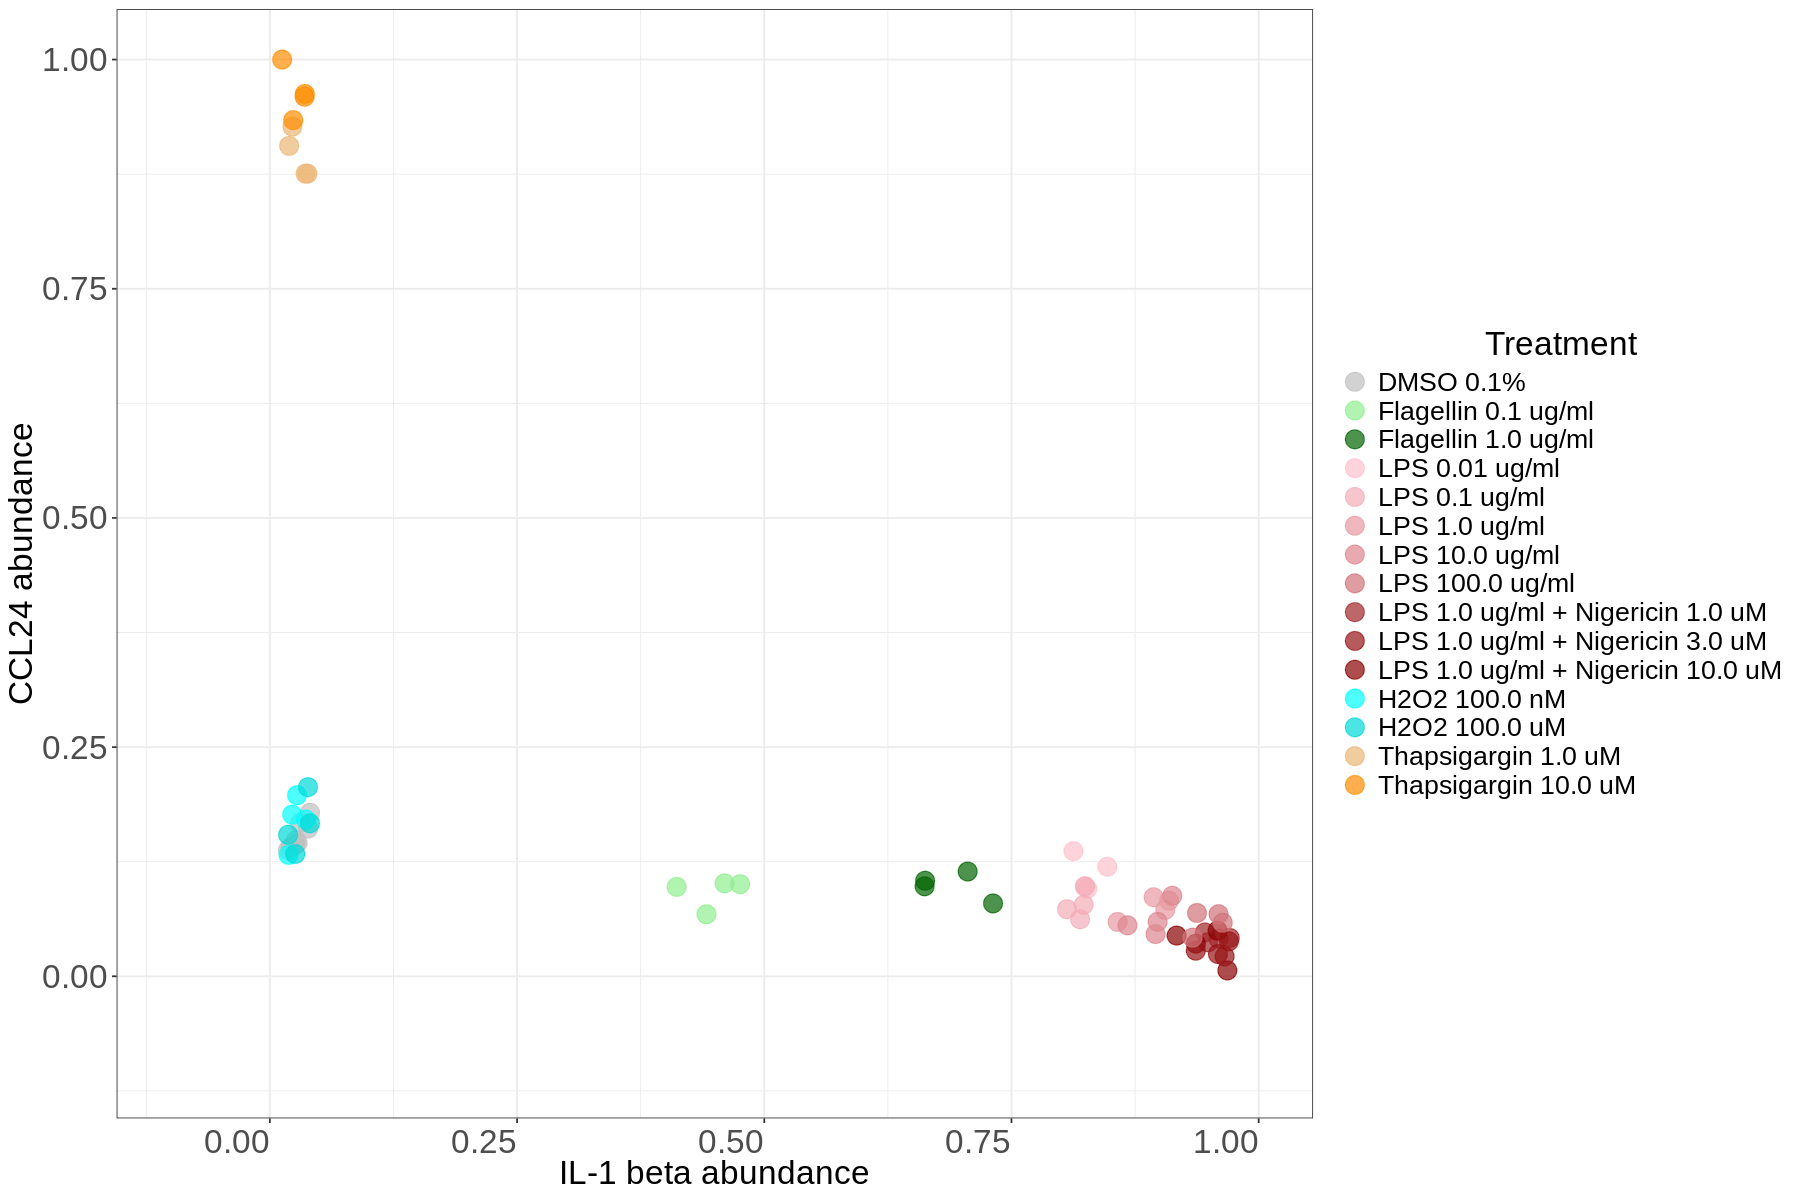

In [9]:
# set plot size
width = 15
height = 10
options(repr.plot.width=width, repr.plot.height=height)
cytokine_scatter_plot <- (
    cytokine_scatter_plot 
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%',
        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',
        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',
        'H2O2 100.0 nM',
        'H2O2 100.0 uM',
        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM'
        ),
        values = colors_3)
)

cytokine_scatter_plot


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


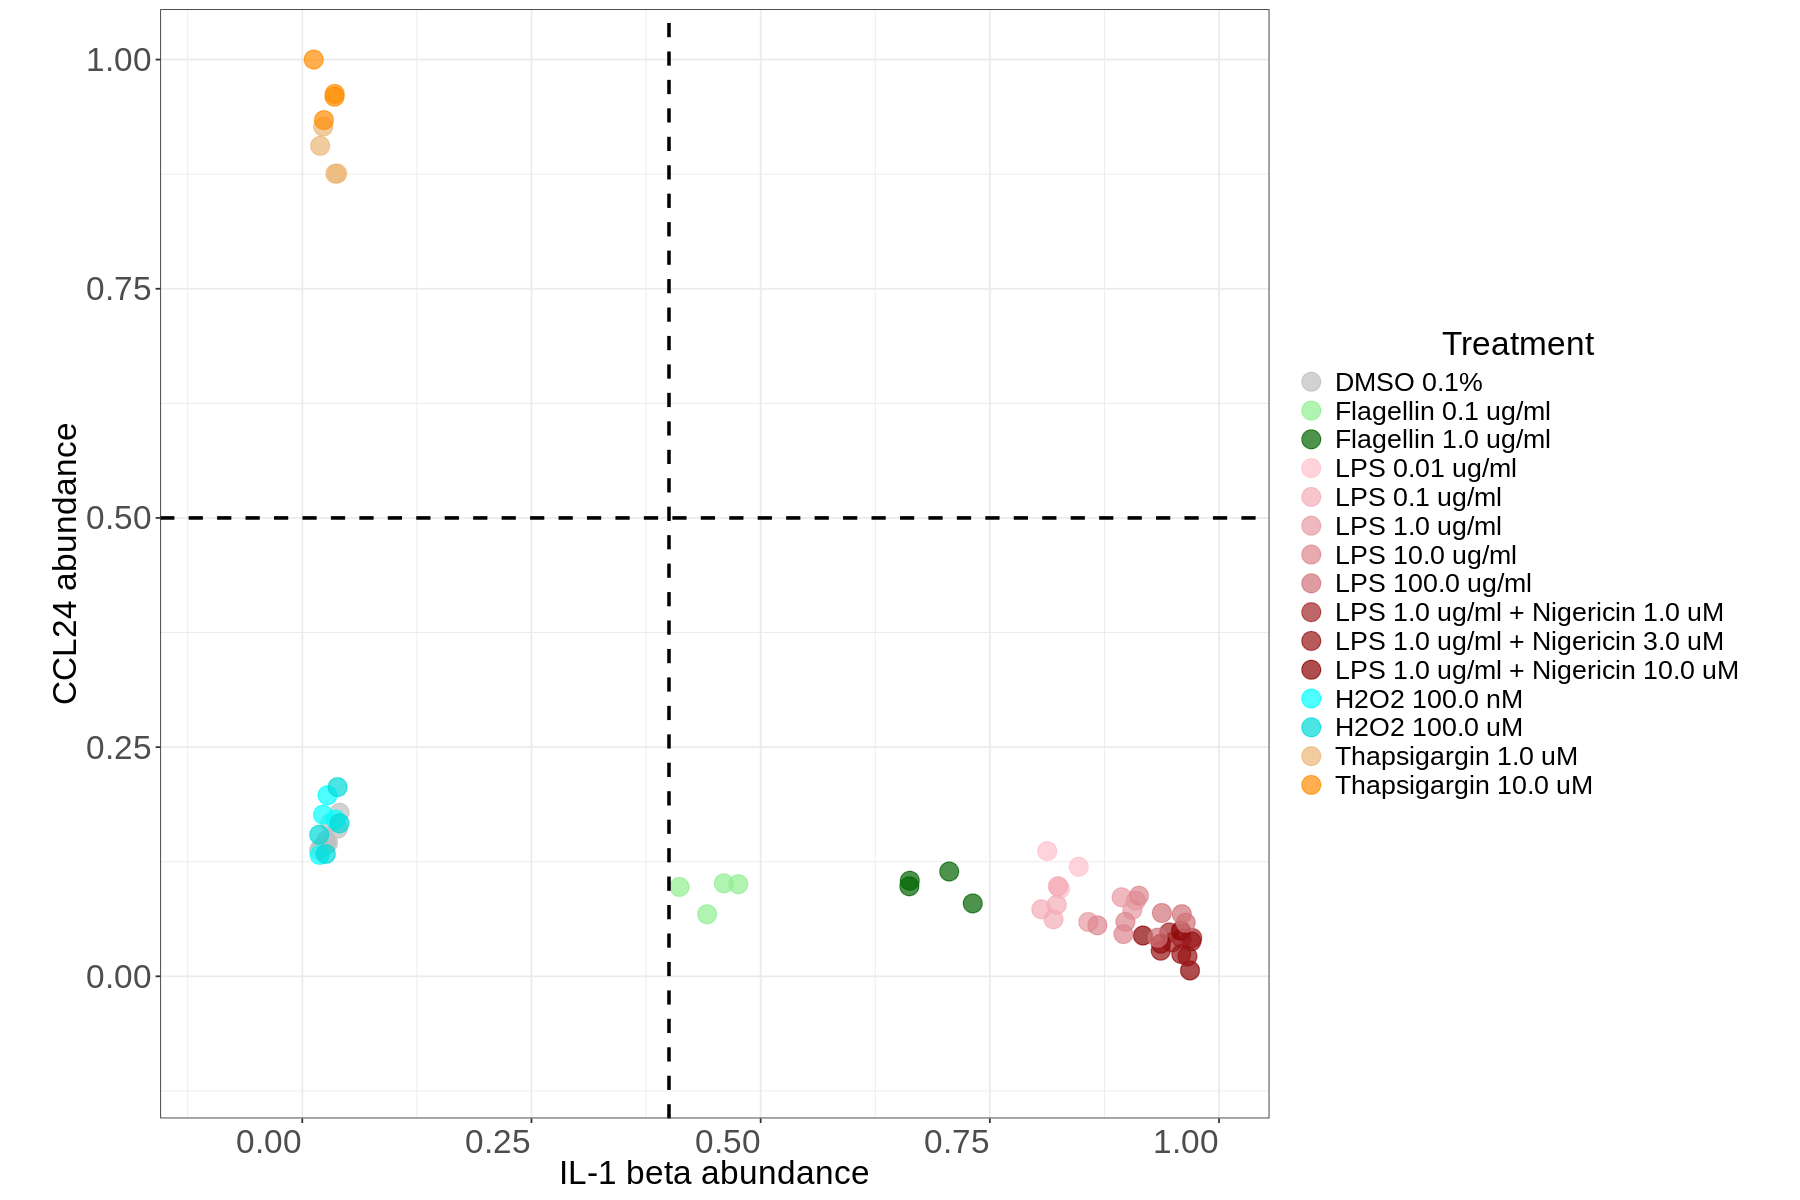

In [10]:
# cytokine_scatter_plot add gates 
cytokine_scatter_plot <- (
    cytokine_scatter_plot
    + geom_vline(xintercept = 0.4, linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1)
)
# fix the coordinates
cytokine_scatter_plot <- (
    cytokine_scatter_plot
    + ggplot2::coord_fixed()
)
cytokine_scatter_plot



### Bar plots of cytokine concentration

In [11]:
# import melted dataframes
# Figure 2A

# Load data
data_path_cytokine_values_melted <- file.path("..","..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.parquet")
cytokine_values_melted <- arrow::read_parquet(data_path_cytokine_values_melted)
# filter out the treatments that are not in the list
cytokine_values_melted <- cytokine_values_melted[cytokine_values_melted$oneb_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]


In [12]:
# select a few cytokines to visualize
cytokine_values_melted <- cytokine_values_melted[cytokine_values_melted$cytokine %in% c(
    "IL-1 beta [NSU]",
    "TNF alpha [NSU]",
    "CCL24 [NSU]",
    "IL-18 [NSU]",
    "IL-6 [NSU]",
    "Osteopontin (OPN) [NSU]",
    "CCL13 [NSU]",
    "IL-2 [NSU]"
    ),]


In [13]:
# set the order of the cytokines
cytokine_values_melted$Cytokine <- factor(cytokine_values_melted$cytokine, levels = c(
    "IL-1 beta [NSU]",
    "TNF alpha [NSU]",
    
    "IL-18 [NSU]",
    "IL-6 [NSU]",
    
    
    "IL-2 [NSU]",
    "Osteopontin (OPN) [NSU]",
    "CCL13 [NSU]",
    "CCL24 [NSU]"
    ))


In [14]:
# aggregate the data to get both the mean and the standard deviation
cytokine_values_melted_agg <- cytokine_values_melted %>% 
    group_by(cytokine, oneb_Treatment_Dose_Inhibitor_Dose) %>% 
    summarise(
        mean = mean(cytokine_value),
        sd = sd(cytokine_value)
    )
head(cytokine_values_melted_agg)


`summarise()` has grouped output by 'cytokine'. You can override using the
`.groups` argument.


cytokine,oneb_Treatment_Dose_Inhibitor_Dose,mean,sd
<chr>,<chr>,<dbl>,<dbl>
CCL13 [NSU],DMSO_0.100_%_DMSO_0.025_%,0.12418779,0.02840384
CCL13 [NSU],Flagellin_0.100_ug_per_ml_DMSO_0.025_%,0.13711747,0.03485610
CCL13 [NSU],Flagellin_1.000_ug_per_ml_DMSO_0.025_%,0.09824529,0.04856094
CCL13 [NSU],H2O2_100.000_nM_DMSO_0.025_%,0.11012973,0.02676393
CCL13 [NSU],H2O2_100.000_uM_DMSO_0.025_%,0.14471647,0.01453055
CCL13 [NSU],LPS_0.010_ug_per_ml_DMSO_0.025_%,0.13098658,0.02729576


In [15]:
# mutate the names of each treatment
cytokine_values_melted_agg <- cytokine_values_melted_agg %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))

# mutate the names of each treatment
cytokine_values_melted_agg <- cytokine_values_melted_agg %>%
    mutate(cytokine = case_when(
        cytokine == "CCL13 [NSU]" ~ "CCL13",
        cytokine =="IL-1 beta [NSU]" ~ "IL-1 beta",
        cytokine =="TNF alpha [NSU]" ~ "TNF alpha",
        cytokine =="IL-18 [NSU]" ~ "IL-18",
        cytokine =="IL-6 [NSU]" ~ "IL-6",
        cytokine =="IL-2 [NSU]" ~ "IL-2",
        cytokine =="Osteopontin (OPN) [NSU]" ~ "Osteopontin",
        cytokine =="CCL13 [NSU]" ~ "CCL13",
        cytokine =="CCL24 [NSU]" ~ "CCL24"
    ))

cytokine_order = c(
    "IL-1 beta",
    "TNF alpha",
    "IL-18",
    "IL-6",
    "IL-2",
    "Osteopontin",
    "CCL13",
    "CCL24"
    )

cytokine_values_melted_agg$cytokine <- factor(cytokine_values_melted_agg$cytokine, levels = cytokine_order)

treatment_order <- c(
    'DMSO 0.1%',
    'Flagellin 0.1 ug/ml',
    'Flagellin 1.0 ug/ml',
    'LPS 0.01 ug/ml',
    'LPS 0.1 ug/ml',
    'LPS 1.0 ug/ml',
    'LPS 10.0 ug/ml',
    'LPS 100.0 ug/ml',
    'LPS 1.0 ug/ml + Nigericin 1.0 uM',
    'LPS 1.0 ug/ml + Nigericin 3.0 uM',
    'LPS 1.0 ug/ml + Nigericin 10.0 uM',
    'H2O2 100.0 nM',
    'H2O2 100.0 uM',
    'Thapsigargin 1.0 uM',
    'Thapsigargin 10.0 uM'
)
cytokine_values_melted_agg$oneb_Treatment_Dose_Inhibitor_Dose <- factor(cytokine_values_melted_agg$oneb_Treatment_Dose_Inhibitor_Dose, levels = treatment_order)


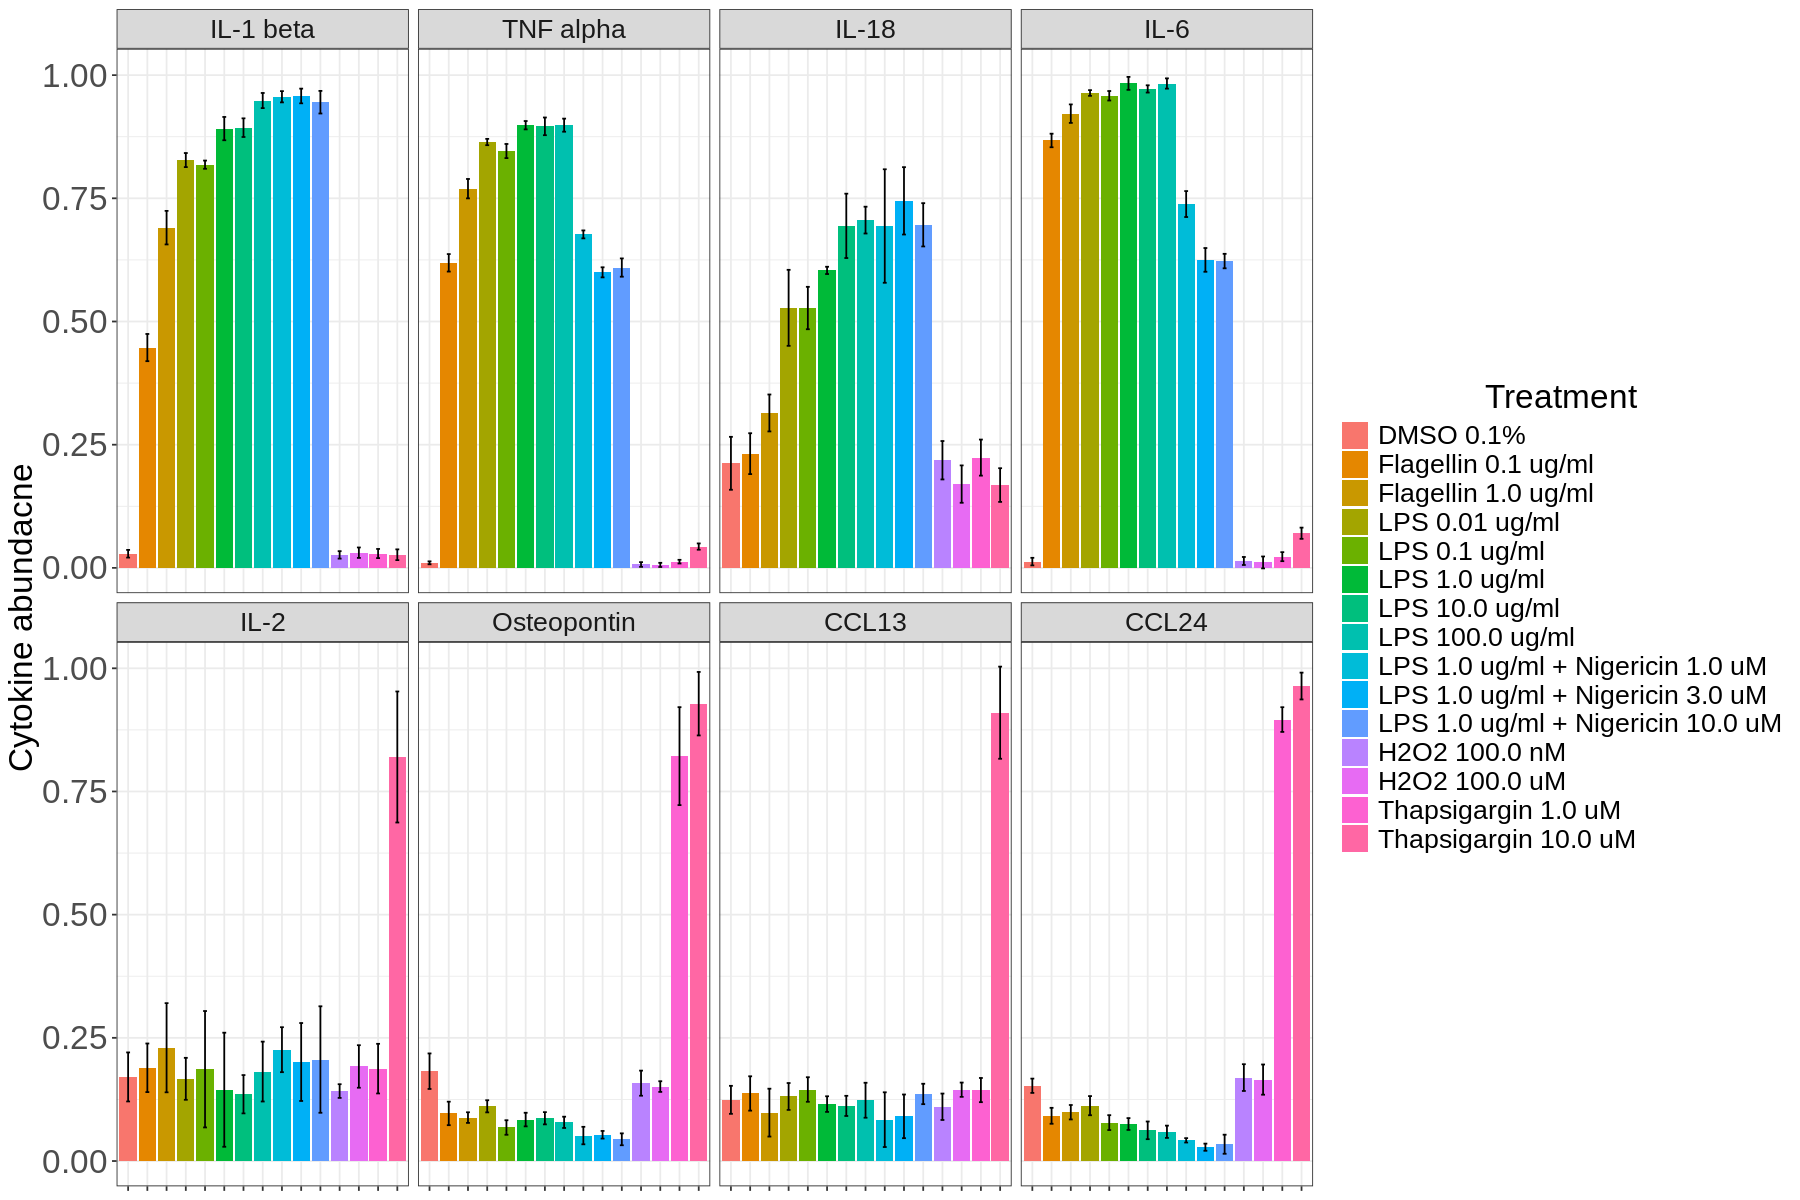

In [16]:
# set plot size 
options(repr.plot.width=15, repr.plot.height=10)
# make the bar plots for the cytokine values
cytokine_bar_plot <- (
    ggplot(data=cytokine_values_melted_agg,
           aes(x=oneb_Treatment_Dose_Inhibitor_Dose,
                y=mean,
                fill=oneb_Treatment_Dose_Inhibitor_Dose))
    + geom_bar(stat="identity", position="dodge")
    + theme_bw()
    + geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2, position=position_dodge(.9))
    + facet_wrap(.~cytokine, nrow =2)
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + ylab("Cytokine abundacne")
    + xlab("Treatment")
    # strip x axis labels
    
    + figure_theme
    + theme(axis.text.x = element_blank())
    + labs(fill = "Treatment", hjust = 0.5, size = 20)
    + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
     # remove x axis labels
     + theme(
          axis.title.x = element_blank(),
     )
    

)

cytokine_bar_plot


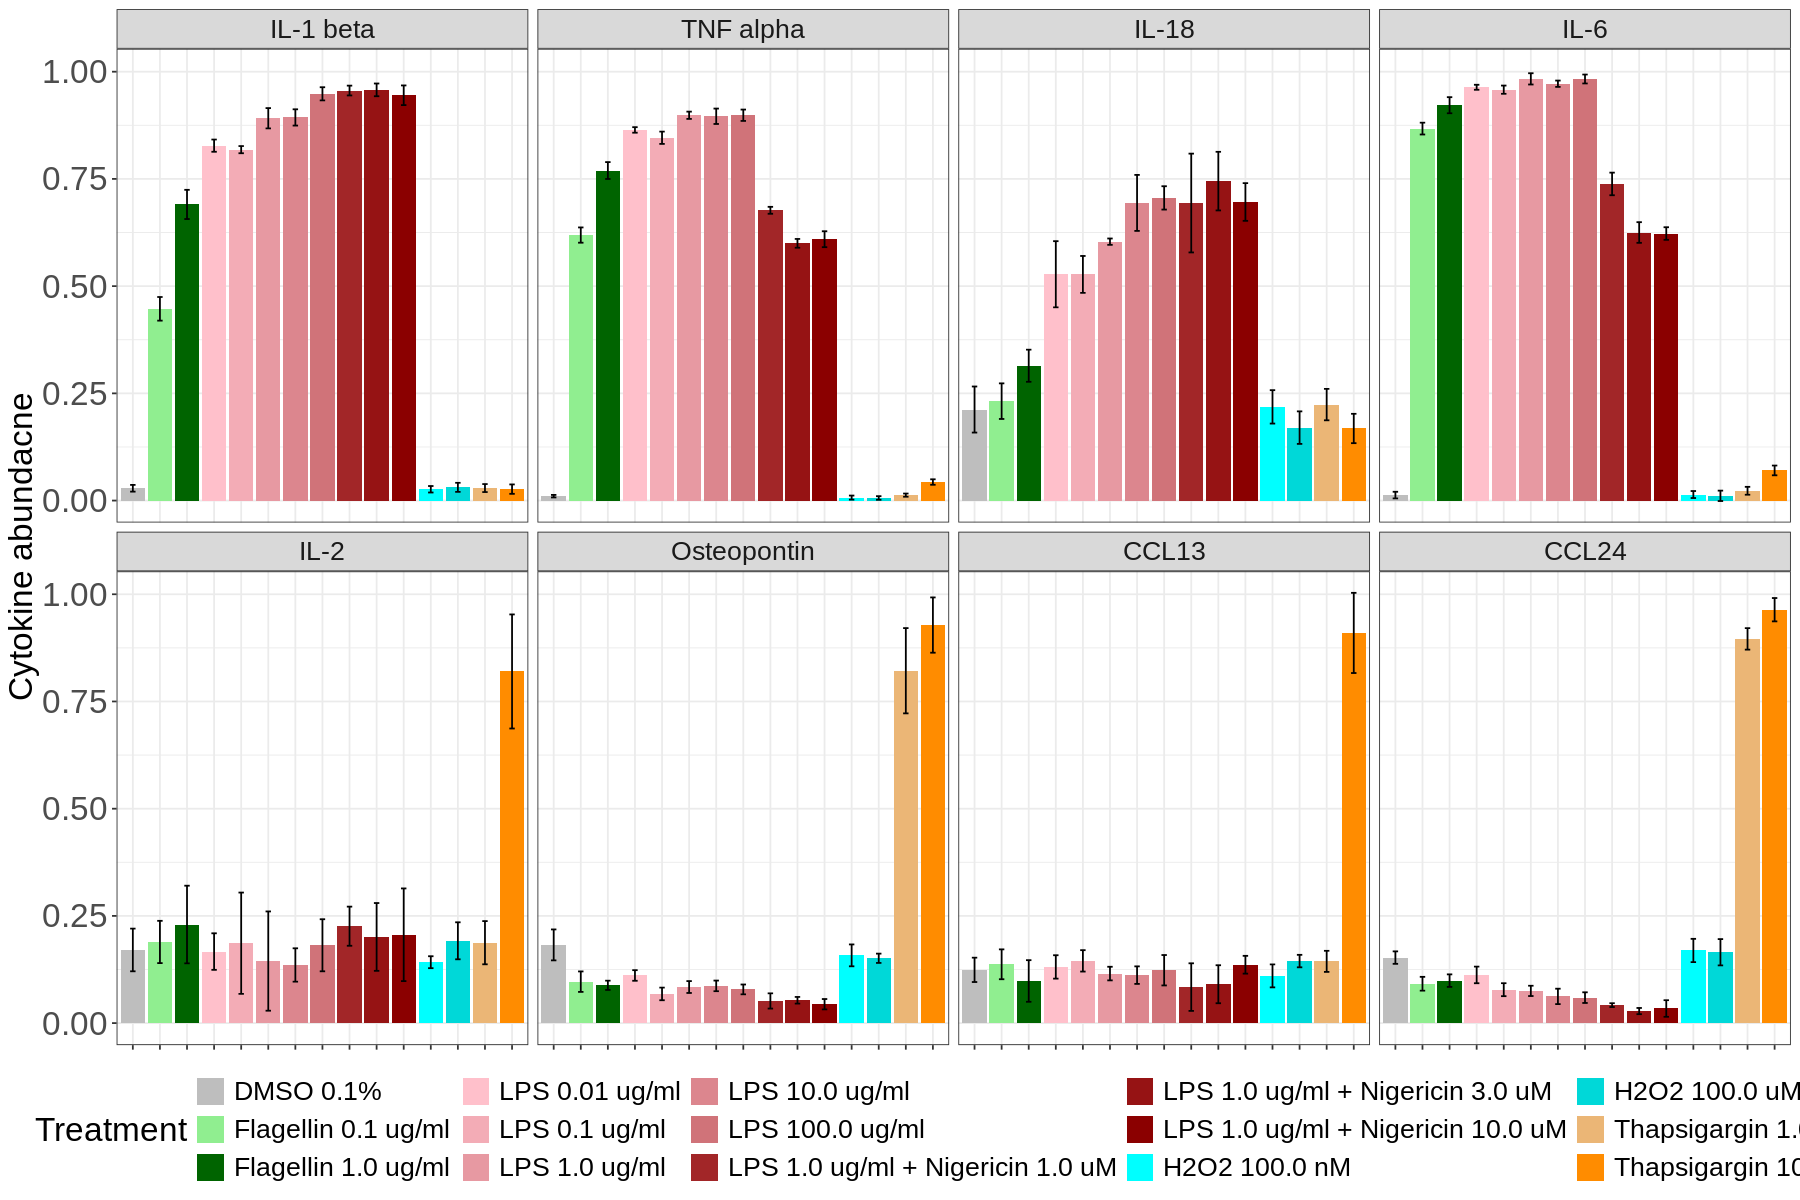

In [17]:
# change color of bars
cytokine_bar_plot <- (
    cytokine_bar_plot
    + scale_fill_manual(
        values = colors_3
    )
    # move legend to the bottom
    + theme(legend.position = "bottom", legend.box = "horizontal")
    # change the nunmber of rows in the legend
    + guides(fill = guide_legend(nrow = 3))
)

cytokine_bar_plot

### Heatmap of cytokine concentration

In [18]:
# import melted dataframes
# Figure 2A

# Load data
data_path_cytokine_values_melted <- file.path("..","..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.parquet")
cytokine_values_melted <- arrow::read_parquet(data_path_cytokine_values_melted)
# filter out the treatments that are not in the list
cytokine_values_melted <- subset(cytokine_values_melted, select = -Metadata_position_x)


In [19]:
# drop two columns by name 
# aggregate the cytokine values across the treatments and cytokine
cytokine_values_agg <- cytokine_values_melted %>%
    group_by(cytokine,oneb_Treatment_Dose_Inhibitor_Dose) %>%
    summarise_all(mean)


In [20]:
unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose)

[1] "Disulfiram_0.100_uM_DMSO_0.025_%"                            
 [2] "Disulfiram_1.000_uM_DMSO_0.025_%"                            
 [3] "Disulfiram_2.500_uM_DMSO_0.025_%"                            
 [4] "DMSO_0.100_%_DMSO_0.025_%"                                   
 [5] "DMSO_0.100_%_DMSO_1.000_%"                                   
 [6] "DMSO_0.100_%_Z-VAD-FMK_100.000_uM"                           
 [7] "DMSO_0.100_%_Z-VAD-FMK_30.000_uM"                            
 [8] "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"                      
 [9] "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM"               
[10] "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"                      
[11] "H2O2_100.000_nM_DMSO_0.025_%"                                
[12] "H2O2_100.000_uM_Disulfiram_1.000_uM"                         
[13] "H2O2_100.000_uM_DMSO_0.025_%"                                
[14] "H2O2_100.000_uM_Z-VAD-FMK_100.000_uM"                        
[15] "LPS_0.010_ug_per_ml_DMSO_0.025_%"                            
[16] "LPS_0.100_ug_per_ml_DMSO_0.025_%"                            
[17] "LPS_1.000_ug_per_ml_DMSO_0.025_%"                            
[18] "LPS_10.000_ug_per_ml_Disulfiram_0.100_uM"                    
[19] "LPS_10.000_ug_per_ml_Disulfiram_1.000_uM"                    
[20] "LPS_10.000_ug_per_ml_Disulfiram_2.500_uM"                    
[21] "LPS_10.000_ug_per_ml_DMSO_0.025_%"                           
[22] "LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM"                   
[23] "LPS_100.000_ug_per_ml_DMSO_0.025_%"                          
[24] "LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%"         
[25] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM" 
[26] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%"        
[27] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM"
[28] "LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%"         
[29] "LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%"       
[30] "LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%"      
[31] "LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%"       
[32] "Media"                                                       
[33] "Thapsigargin_1.000_uM_DMSO_0.025_%"                          
[34] "Thapsigargin_10.000_uM_DMSO_0.025_%"                         
[35] "Topotecan_10.000_nM_DMSO_0.025_%"                            
[36] "Topotecan_20.000_nM_DMSO_0.025_%"                            
[37] "Topotecan_5.000_nM_DMSO_0.025_%"

In [21]:
length(unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose))
# mutate the names of each treatment
cytokine_values_agg <- cytokine_values_agg %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% + DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% + Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml + DMSO 0.0%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml + DMSO 0.0%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml + Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml + Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM + Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM + Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM + DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose == 'Media' ~ "Media"
    )
)
length(unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose))
unique(cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose)


[1] 37

[1] 37

[1] "Disulfiram 0.1 uM + DMSO 0.025%"                       
 [2] "Disulfiram 1.0 uM + DMSO 0.025%"                       
 [3] "Disulfiram 2.5 uM + DMSO 0.025%"                       
 [4] "DMSO 0.1% + DMSO 0.025%"                               
 [5] "DMSO 0.1% + DMSO 1.0%"                                 
 [6] "DMSO 0.1% + Z-VAD-FMK 100.0 uM"                        
 [7] "DMSO 0.1% + Z-VAD-FMK 30.0 uM"                         
 [8] "Flagellin 0.1 ug/ml + DMSO 0.025%"                     
 [9] "Flagellin 1.0 ug/ml + Disulfiram 1.0 uM"               
[10] "Flagellin 1.0 ug/ml + DMSO 0.025%"                     
[11] "H2O2 100.0 nM + DMSO 0.025%"                           
[12] "H2O2 100.0 uM + Disulfiram 1.0 uM"                     
[13] "H2O2 100.0 uM + DMSO 0.025%"                           
[14] "H2O2 100.0 uM + Z-VAD-FMK 100.0 uM"                    
[15] "LPS 0.01 ug/ml + DMSO 0.025%"                          
[16] "LPS 0.1 ug/ml + DMSO 0.025%"                           
[17] "LPS 1.0 ug/ml + DMSO 0.025%"                           
[18] "LPS 10.0 ug/ml + Disulfiram 0.1 uM"                    
[19] "LPS 10.0 ug/ml + Disulfiram 1.0 uM"                    
[20] "LPS 10.0 ug/ml + Disulfiram 2.5 uM"                    
[21] "LPS 10.0 ug/ml + DMSO 0.025%"                          
[22] "LPS 10.0 ug/ml + Z-VAD-FMK 100.0 uM"                   
[23] "LPS 100.0 ug/ml + DMSO 0.025%"                         
[24] "LPS 1.0 ug/ml + Nigericin 1.0 uM + DMSO 0.025%"        
[25] "LPS 1.0 ug/ml + Nigericin 10.0 uM + Disulfiram 1.0 uM" 
[26] "LPS 1.0 ug/ml + Nigericin 10.0 uM + DMSO 0.025%"       
[27] "LPS 1.0 ug/ml + Nigericin 10.0 uM + Z-VAD-FMK 100.0 uM"
[28] "LPS 1.0 ug/ml + Nigericin 3.0 uM + DMSO 0.025%"        
[29] "LPS 100.0 ug/ml + Nigericin 1.0 uM + DMSO 0.025%"      
[30] "LPS 100.0 ug/ml + Nigericin 10.0 uM + DMSO 0.025%"     
[31] "LPS 100.0 ug/ml + Nigericin 3.0 uM + DMSO 0.025%"      
[32] "Media"                                                 
[33] "Thapsigargin 1.0 uM + DMSO 0.025%"                     
[34] "Thapsigargin 10.0 uM + DMSO 0.025%"                    
[35] "Topotecan 10.0 nM + DMSO 0.025%"                       
[36] "Topotecan 20.0 nM + DMSO 0.025%"                       
[37] "Topotecan 5.0 nM + DMSO 0.025%"

In [22]:
length(unique(cytokine_values_agg$cytokine))
# gsub out '[NSU]' from the cytokine names
cytokine_values_agg$cytokine <- gsub('\\[NSU\\]', '', cytokine_values_agg$cytokine)
length(unique(cytokine_values_agg$cytokine))
    

[1] 187

[1] 187

In [23]:
head(cytokine_values_agg)

cytokine,oneb_Treatment_Dose_Inhibitor_Dose,cytokine_value
<chr>,<chr>,<dbl>
Activin A,Disulfiram 0.1 uM + DMSO 0.025%,0.06730321
Activin A,Disulfiram 1.0 uM + DMSO 0.025%,0.07120969
Activin A,Disulfiram 2.5 uM + DMSO 0.025%,0.07503395
Activin A,DMSO 0.1% + DMSO 0.025%,0.07246874
Activin A,DMSO 0.1% + DMSO 1.0%,0.03793296
Activin A,DMSO 0.1% + Z-VAD-FMK 100.0 uM,0.04165845


In [24]:
# create a matrix of the cytokine values for the clustering and heatmap
# unmelt the data 
cytokine_values_agg <- reshape2::dcast(cytokine_values_agg, oneb_Treatment_Dose_Inhibitor_Dose ~ cytokine, value.var = "cytokine_value", fun.aggregate = mean)
# make oneb_Metadata_Treatment_Dose_Inhibitor_Dose the rownames
rownames(cytokine_values_agg) <- cytokine_values_agg$oneb_Treatment_Dose_Inhibitor_Dose
# drop the column
cytokine_values_agg <- subset(cytokine_values_agg, select = -c(oneb_Treatment_Dose_Inhibitor_Dose))


In [25]:
head(cytokine_values_agg)


,Activin A,AITRL (GITR Ligand),Amphiregulin,Amyloid beta,APRIL,BAFF,BCMA (TNFRSF17),BDNF,BMP2,BMP3,⋯,TWEAK,uPA,VCAM-1,VEGF Receptor 2 (Flk-1),VEGF-A (165),VEGF-C,VEGF-D,VEGFR-1,WISP-1 (CCN4),XCL1 (Lymphotactin)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Disulfiram 0.1 uM + DMSO 0.025%,0.06730321,0.5240792,0.26674889,0.5023795,0.5309348,0.3937257,0.6358177,0.3984310,0.4198017,0.3606192,⋯,0.5166680,0.4767908,0.4605500,0.4115684,0.3381163,0.6802347,0.3854959,0.2440223,0.4071627,0.2291238
Disulfiram 1.0 uM + DMSO 0.025%,0.07120969,0.5096765,0.33319231,0.3673681,0.4838848,0.3172901,0.6965589,0.3153944,0.4113612,0.3360172,⋯,0.3411230,0.2938467,0.3738126,0.4784020,0.3105525,0.5564414,0.4041607,0.1858099,0.4915471,0.2726109
Disulfiram 2.5 uM + DMSO 0.025%,0.07503395,0.3898258,0.26079568,0.3541087,0.4880536,0.4563620,0.6906623,0.2804577,0.3722220,0.2512592,⋯,0.4017739,0.3931795,0.2996615,0.4479463,0.4743071,0.6227738,0.1792508,0.2580256,0.3833620,0.2188123
DMSO 0.1% + DMSO 0.025%,0.07246874,0.4940995,0.23914683,0.4820596,0.4744615,0.3851330,0.6010184,0.2504846,0.4196230,0.3238476,⋯,0.4583241,0.4528880,0.3506292,0.4413733,0.4563148,0.5649021,0.3833757,0.1963640,0.4166624,0.1974226
DMSO 0.1% + DMSO 1.0%,0.03793296,0.5243176,0.03069507,0.4113630,0.4663236,0.4419314,0.6551810,0.2842837,0.5404479,0.2908964,⋯,0.5305307,0.3763025,0.3465639,0.4473434,0.6629754,0.6740278,0.4390040,0.1533047,0.5611511,0.1932183
DMSO 0.1% + Z-VAD-FMK 100.0 uM,0.04165845,0.3752564,0.05343949,0.4534571,0.4793325,0.3365215,0.5873664,0.2822391,0.5846508,0.4748176,⋯,0.4088662,0.4296843,0.3395713,0.3640923,0.5794621,0.7040245,0.3328181,0.1111599,0.4912596,0.6167773


In [26]:
row_dend <- as.dendrogram(hclust(dist(cytokine_values_agg)))
col_dend <- as.dendrogram(hclust(dist(t(cytokine_values_agg))))


In [27]:
# remove '[NSU]' from the column names
colnames(cytokine_values_agg) <- gsub("\\[NSU\\]", "", colnames(cytokine_values_agg))


In [28]:
cytokine_values_agg <- as.matrix(cytokine_values_agg)


png 
  2

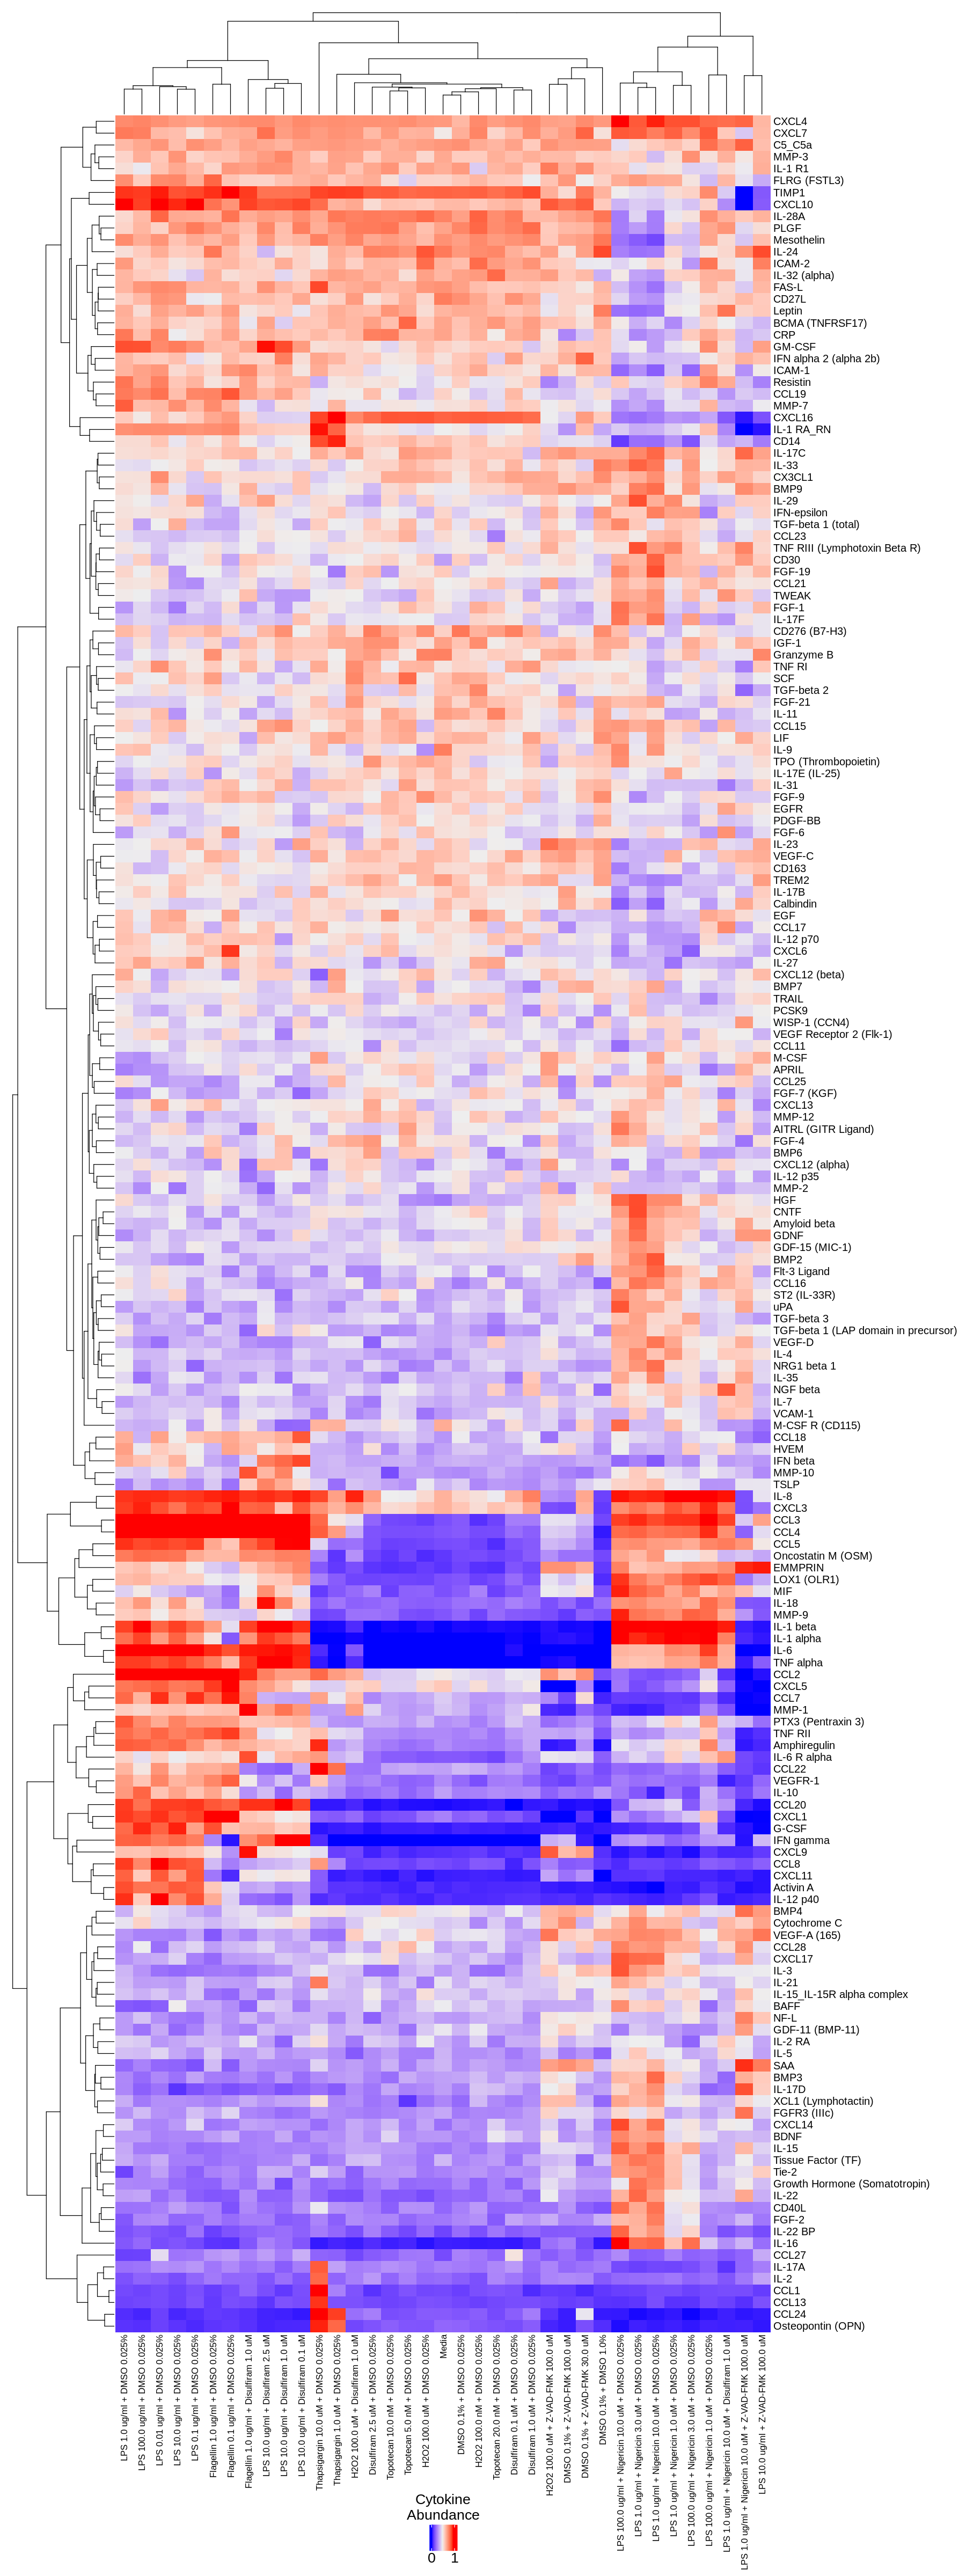

In [29]:
# set plot size 
options(repr.plot.width=15, repr.plot.height=40)
heatmap_plot_all <- (
  Heatmap(
  t(cytokine_values_agg),
  cluster_rows = TRUE,    # Cluster rows
  cluster_columns = TRUE, # Cluster columns
  show_row_names = TRUE,  # Show row names
  show_column_names = TRUE, # Show column names
  column_names_gp = gpar(fontsize = 10), # Column name label formatting
  row_names_gp = gpar(fontsize = 12),    # Row name label formatting
   heatmap_legend_param = list(
                title = "Cytokine\nAbundance", at = c(0, 1), 
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 16), 
                labels_gp = gpar(fontsize = 16),
                direction = "horizontal",
                padding = unit(c(10, 10, 5, 5), "mm"),
                grid_width = unit(5000, "mm"),
                grid_height = unit(10, "mm")
                ),
  # make the tiles rectangular
  rect_gp = gpar(col = NA),
  column_dend_height = unit(4, "cm"), 
  row_dend_width = unit(4, "cm")
    )
)

heatmap_plot_all <- draw(
    heatmap_plot_all, 
    heatmap_legend_side = "bottom", 
    annotation_legend_side = "right",
    # change locaiton of the legend
    merge_legend = TRUE,
    padding = unit(c(5, 5, 5, 15), "mm"),
)


png(file.path("../figures","all_cytokines_heatmap.png"), width = width, height = height, units = "in", res = 600)
# make path if it does not exist
dir.create(file.path("../figures"), showWarnings = FALSE)
heatmap_plot_all
dev.off()
heatmap_plot_all


## Filtered data

In [30]:
# import the tukey test results
tukey_results_path <- file.path("..","..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/tukey_test_results.csv")
# read in the data
tukey_results <- read.csv(tukey_results_path, header = TRUE, sep = ",")

# reload in the cytokine values
data_path_cytokine_values_melted <- file.path("..","..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.parquet")
cytokine_values_melted <- arrow::read_parquet(data_path_cytokine_values_melted)
# filter out the treatments that are not in the list
cytokine_values_melted <- cytokine_values_melted[cytokine_values_melted$oneb_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]
# drop metadata position x
cytokine_values_melted <- subset(cytokine_values_melted, select = -Metadata_position_x)
head(cytokine_values_melted)
# aggregate the cytokine values across the treatments and cytokine
cytokine_values_melted_agg <- cytokine_values_melted %>%
    group_by(oneb_Treatment_Dose_Inhibitor_Dose, cytokine) %>%
    summarise(cytokine_value = mean(cytokine_value))


oneb_Treatment_Dose_Inhibitor_Dose,cytokine,cytokine_value
<chr>,<chr>,<dbl>
DMSO_0.100_%_DMSO_0.025_%,Activin A [NSU],0.09770974
DMSO_0.100_%_DMSO_0.025_%,Activin A [NSU],0.06451266
DMSO_0.100_%_DMSO_0.025_%,Activin A [NSU],0.06185979
DMSO_0.100_%_DMSO_0.025_%,Activin A [NSU],0.06099844
DMSO_0.100_%_DMSO_0.025_%,Activin A [NSU],0.06111581
DMSO_0.100_%_DMSO_0.025_%,Activin A [NSU],0.05323571


`summarise()` has grouped output by 'oneb_Treatment_Dose_Inhibitor_Dose'. You
can override using the `.groups` argument.


In [31]:
# read in the ground truth
ground_truth_path <- file.path(
    "../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml"
)
ground_truth <- parseTOML(ground_truth_path)
apoptosis_ground_truth_list <- ground_truth$Apoptosis$apoptosis_groups_list
pyroptosis_ground_truth_list <- ground_truth$Pyroptosis$pyroptosis_groups_list
control_ground_truth_list <- ground_truth$Healthy$healthy_groups_list

In [32]:
# make a new column that is the treatment group based on the ground truth data
cytokine_values_melted_agg$group <- ifelse(cytokine_values_melted_agg$oneb_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cytokine_values_melted_agg$oneb_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cytokine_values_melted_agg$oneb_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cytokine_values_melted_agg$group <- factor(cytokine_values_melted_agg$group, levels = c("Control","Apoptosis", "Pyroptosis"))

In [33]:
cytokine_values_melted_agg_filtered <- cytokine_values_melted_agg[cytokine_values_melted_agg$cytokine %in% unique(tukey_results$cytokine),]
head(cytokine_values_melted_agg_filtered)


oneb_Treatment_Dose_Inhibitor_Dose,cytokine,cytokine_value,group
<chr>,<chr>,<dbl>,<fct>
DMSO_0.100_%_DMSO_0.025_%,Activin A [NSU],0.07246874,Control
DMSO_0.100_%_DMSO_0.025_%,AITRL (GITR Ligand) [NSU],0.49409949,Control
DMSO_0.100_%_DMSO_0.025_%,Amphiregulin [NSU],0.23914683,Control
DMSO_0.100_%_DMSO_0.025_%,Amyloid beta [NSU],0.48205962,Control
DMSO_0.100_%_DMSO_0.025_%,APRIL [NSU],0.47446146,Control
DMSO_0.100_%_DMSO_0.025_%,BAFF [NSU],0.38513295,Control


In [34]:
# mutate the names of each treatment
cytokine_values_melted_agg_filtered <- cytokine_values_melted_agg_filtered %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))


In [35]:
head(cytokine_values_melted_agg_filtered)


oneb_Treatment_Dose_Inhibitor_Dose,cytokine,cytokine_value,group
<chr>,<chr>,<dbl>,<fct>
DMSO 0.1%,Activin A [NSU],0.07246874,Control
DMSO 0.1%,AITRL (GITR Ligand) [NSU],0.49409949,Control
DMSO 0.1%,Amphiregulin [NSU],0.23914683,Control
DMSO 0.1%,Amyloid beta [NSU],0.48205962,Control
DMSO 0.1%,APRIL [NSU],0.47446146,Control
DMSO 0.1%,BAFF [NSU],0.38513295,Control


In [36]:
cytokine_values_melted_agg_filtered$old_cytokine <- cytokine_values_melted_agg_filtered$cytokine


In [37]:

# fix the col name
cytokine_values_melted_agg_filtered <- cytokine_values_melted_agg_filtered %>% 
  mutate(cytokine = case_when(
    cytokine == "MMP-1 [NSU]" ~ "MMP-1",
    cytokine == "VEGFR-1 [NSU]" ~ "VEGFR-1",
    cytokine == "CCL4 [NSU]" ~ "CCL4",
    cytokine == "MMP-12 [NSU]" ~ "MMP-12",
    cytokine == "CCL18 [NSU]" ~ "CCL18",
    cytokine == "IL-9 [NSU]" ~ "IL-9",
    cytokine == "TWEAK [NSU]" ~ "TWEAK",
    cytokine == "EGFR [NSU]" ~ "EGFR",
    cytokine == "IL-21 [NSU]" ~ "IL-21",
    cytokine == "FGF-1 [NSU]" ~ "FGF-1",
    cytokine == "FAS-L [NSU]" ~ "FAS-L",
    cytokine == "CXCL12 (beta) [NSU]" ~ "CXCL12 (beta)",
    cytokine == "CXCL12 (alpha) [NSU]" ~ "CXCL12 (alpha)",
    cytokine == "CXCL14 [NSU]" ~ "CXCL14",
    cytokine == "HGF [NSU]" ~ "HGF",
    cytokine == "IL-3 [NSU]" ~ "IL-3",
    cytokine == "CXCL7 [NSU]" ~ "CXCL7",
    cytokine == "CCL25 [NSU]" ~ "CCL25",
    cytokine == "BMP9 [NSU]" ~ "BMP9",
    cytokine == "IL-12 p35 [NSU]" ~ "IL-12 p35",
    cytokine == "CCL16 [NSU]" ~ "CCL16",
    cytokine == "CCL2 [NSU]" ~ "CCL2",
    cytokine == "LIF [NSU]" ~ "LIF",
    cytokine == "CXCL9 [NSU]" ~ "CXCL9",
    cytokine == "CNTF [NSU]" ~ "CNTF",
    cytokine == "TSLP [NSU]" ~ "TSLP",
    cytokine == "Flt-3 Ligand [NSU]" ~ "Flt-3 Ligand",
    cytokine == "CD14 [NSU]" ~ "CD14",
    cytokine == "IL-16 [NSU]" ~ "IL-16",
    cytokine == "FGF-21 [NSU]" ~ "FGF-21",
    cytokine == "IL-29 [NSU]" ~ "IL-29",
    cytokine == "IL-17C [NSU]" ~ "IL-17C",
    cytokine == "IFN-epsilon [NSU]" ~ "IFN-epsilon",
    cytokine == "PCSK9 [NSU]" ~ "PCSK9",
    cytokine == "TPO (Thrombopoietin) [NSU]" ~ "Thrombopoietin",
    cytokine == "TREM2 [NSU]" ~ "TREM2",
    cytokine == "Growth Hormone (Somatotropin) [NSU]" ~ "Somatotropin",
    cytokine == "CCL1 [NSU]" ~ "CCL1",
    cytokine == "LOX1 (OLR1) [NSU]" ~ "LOX1 (OLR1)",
    cytokine == "MMP-3 [NSU]" ~ "MMP-3",
    cytokine == "IL-32 (alpha) [NSU]" ~ "IL-32 (alpha)",
    cytokine == "IL-7 [NSU]" ~ "IL-7",
    cytokine == "CCL21 [NSU]" ~ "CCL21",
    cytokine == "CD276 (B7-H3) [NSU]" ~ "CD276 (B7-H3)",
    cytokine == "IL-2 RA [NSU]" ~ "IL-2 RA",
    cytokine == "Calbindin [NSU]" ~ "Calbindin",
    cytokine == "CCL3 [NSU]" ~ "CCL3",
    cytokine == "ICAM-1 [NSU]" ~ "ICAM-1",
    cytokine == "IL-17A [NSU]" ~ "IL-17A",
    cytokine == "CCL28 [NSU]" ~ "CCL28",
    cytokine == "TIMP1 [NSU]" ~ "TIMP1",
    cytokine == "GDF-15 (MIC-1) [NSU]" ~ "GDF-15 (MIC-1)",
    cytokine == "CXCL17 [NSU]" ~ "CXCL17",
    cytokine == "M-CSF R (CD115) [NSU]" ~ "M-CSF R (CD115)",
    cytokine == "CCL7 [NSU]" ~ "CCL7",
    cytokine == "Granzyme B [NSU]" ~ "Granzyme B",
    cytokine == "CXCL4 [NSU]" ~ "CXCL4",
    cytokine == "PDGF-BB [NSU]" ~ "PDGF-BB",
    cytokine == "CX3CL1 [NSU]" ~ "CX3CL1",
    cytokine == "FGF-6 [NSU]" ~ "FGF-6",
    cytokine == "IL-35 [NSU]" ~ "IL-35",
    cytokine == "MMP-7 [NSU]" ~ "MMP-7",
    cytokine == "GM-CSF [NSU]" ~ "GM-CSF",
    cytokine == "CCL24 [NSU]" ~ "CCL24",
    cytokine == "IL-12 p40 [NSU]" ~ "IL-12 p40",
    cytokine == "IL-5 [NSU]" ~ "IL-5",
    cytokine == "BCMA (TNFRSF17) [NSU]" ~ "BCMA (TNFRSF17)",
    cytokine == "Tissue Factor (TF) [NSU]" ~ "Tissue Factor",
    cytokine == "IL-1 beta [NSU]" ~ "IL-1 beta",
    cytokine == "CD30 [NSU]" ~ "CD30",
    cytokine == "CCL27 [NSU]" ~ "CCL27",
    cytokine == "ICAM-2 [NSU]" ~ "ICAM-2",
    cytokine == "CXCL16 [NSU]" ~ "CXCL16",
    cytokine == "VEGF-A (165) [NSU]" ~ "VEGF-A (165)",
    cytokine == "IL-2 [NSU]" ~ "IL-2",
    cytokine == "HVEM [NSU]" ~ "HVEM",
    cytokine == "PTX3 (Pentraxin 3) [NSU]" ~ "PTX3",
    cytokine == "IL-1 alpha [NSU]" ~ "IL-1 alpha",
    cytokine == "CXCL3 [NSU]" ~ "CXCL3",
    cytokine == "Oncostatin M (OSM) [NSU]" ~ "Oncostatin M",
    cytokine == "CCL8 [NSU]" ~ "CCL8",
    cytokine == "CCL15 [NSU]" ~ "CCL15",
    cytokine == "FLRG (FSTL3) [NSU]" ~ "FLRG",
    cytokine == "CXCL5 [NSU]" ~ "CXCL5",
    cytokine == "CD163 [NSU]" ~ "CD163",
    cytokine == "IL-17E (IL-25) [NSU]" ~ "IL-17E",
    cytokine == "NF-L [NSU]" ~ "NF-L",
    cytokine == "alpha 2b) [NSU]" ~ "IFN alpha 2",
    cytokine == "TNF RI [NSU]" ~ "TNF RI",
    cytokine == "CD40L [NSU]" ~ "CD40L",
    cytokine == "IFN beta [NSU]" ~ "IFN beta",
    cytokine == "VEGF Receptor 2 (Flk-1) [NSU]" ~ "VEGF Receptor 2",
    cytokine == "BDNF [NSU]" ~ "BDNF",
    cytokine == "Amyloid beta [NSU]" ~ "Amyloid beta",
    cytokine == "MMP-2 [NSU]" ~ "MMP-2",
    cytokine == "SAA [NSU]" ~ "SAA",
    cytokine == "uPA [NSU]" ~ "uPA",
    cytokine == "IL-22 BP [NSU]" ~ "IL-22 BP",
    cytokine == "TRAIL [NSU]" ~ "TRAIL",
    cytokine == "Mesothelin [NSU]" ~ "Mesothelin",
    cytokine == "Activin A [NSU]" ~ "Activin A",
    cytokine == "MMP-9 [NSU]" ~ "MMP-9",
    cytokine == "CCL13 [NSU]" ~ "CCL13",
    cytokine == "CXCL11 [NSU]" ~ "CXCL11",
    cytokine == "IL-31 [NSU]" ~ "IL-31",
    cytokine == "MIF [NSU]" ~ "MIF",
    cytokine == "BMP7 [NSU]" ~ "BMP7",
    cytokine == "IL-12 p70 [NSU]" ~ "IL-12 p70",
    cytokine == "CCL19 [NSU]" ~ "CCL19",
    cytokine == "CCL5 [NSU]" ~ "CCL5",
    cytokine == "IL-33 [NSU]" ~ "IL-33",
    cytokine == "IL-22 [NSU]" ~ "IL-22",
    cytokine == "CCL11 [NSU]" ~ "CCL11",
    cytokine == "IL-8 [NSU]" ~ "IL-8",
    cytokine == "SCF [NSU]" ~ "SCF",
    cytokine == "TNF RII [NSU]" ~ "TNF RII",
    cytokine == "FGF-2 [NSU]" ~ "FGF-2",
    cytokine == "Leptin [NSU]" ~ "Leptin",
    cytokine == "CXCL13 [NSU]" ~ "CXCL13",
    cytokine == "TNF alpha [NSU]" ~ "TNF alpha",
    cytokine == "IL-4 [NSU]" ~ "IL-4",
    cytokine == "CCL23 [NSU]" ~ "CCL23",
    cytokine == "IGF-1 [NSU]" ~ "IGF-1",
    cytokine == "FGF-4 [NSU]" ~ "FGF-4",
    cytokine == "GDF-11 (BMP-11) [NSU]" ~ "GDF-11 (BMP-11)",
    cytokine == "IL-10 [NSU]" ~ "IL-10",
    cytokine == "IL-23 [NSU]" ~ "IL-23",
    cytokine == "TNF RIII (Lymphotoxin Beta R) [NSU]" ~ "TNF RIII",
    cytokine == "IL-17B [NSU]" ~ "IL-17B",
    cytokine == "ST2 (IL-33R) [NSU]" ~ "ST2 (IL-33R)",
    cytokine == "PLGF [NSU]" ~ "PLGF",
    cytokine == "VEGF-D [NSU]" ~ "VEGF-D",
    cytokine == "XCL1 (Lymphotactin) [NSU]" ~ "XCL1",
    cytokine == "GDNF [NSU]" ~ "GDNF",
    cytokine == "C5 [NSU]" ~ "C5",
    cytokine == "IL-1 RA" ~ "IL-1 RA",
    cytokine == "IL-17D [NSU]" ~ "IL-17D",
    cytokine == "IL-27 [NSU]" ~ "IL-27",
    cytokine == "Osteopontin (OPN) [NSU]" ~ "Osteopontin",
    cytokine == "FGF-9 [NSU]" ~ "FGF-9",
    cytokine == "BAFF [NSU]" ~ "BAFF",
    cytokine == "TGF-beta 3 [NSU]" ~ "TGF-beta 3",
    cytokine == "EGF [NSU]" ~ "EGF",
    cytokine == "IL-5 [NSU]" ~ "IL-5",
    cytokine == "FGF-7 (KGF) [NSU]" ~ "FGF-7 (KGF)",
    cytokine == "APRIL [NSU]" ~ "APRIL",
    cytokine == "WISP-1 (CCN4) [NSU]" ~ "WISP-1 (CCN4)",
    cytokine == "CCL22 [NSU]" ~ "CCL22",
    cytokine == "FGF-19 [NSU]" ~ "FGF-19",
    cytokine == "M-CSF [NSU]" ~ "M-CSF",
    cytokine == "CXCL10 [NSU]" ~ "CXCL10",
    cytokine == "TGF-beta 1 (total) [NSU]" ~ "TGF-beta 1 ",
    cytokine == "Tie-2 [NSU]" ~ "Tie-2",
    cytokine == "TGF-beta 1 (LAP domain in precursor) [NSU]" ~ "TGF-beta 1",
    cytokine == "FGFR3 (IIIc) [NSU]" ~ "FGFR3 (IIIc)",
    cytokine == "AITRL (GITR Ligand) [NSU]" ~ "AITRL (GITR Ligand)",
    cytokine == "Amphiregulin [NSU]" ~ "Amphiregulin",
    cytokine == "BMP4 [NSU]" ~ "BMP4",
    cytokine == "G-CSF [NSU]" ~ "G-CSF",
    cytokine == "TGF-beta 2 [NSU]" ~ "TGF-beta 2",
    cytokine == "IL-6 R alpha [NSU]" ~ "IL-6 R alpha",
    cytokine == "BMP6 [NSU]" ~ "BMP6",
    cytokine == "NGF beta [NSU]" ~ "NGF beta",
    cytokine == "IL-1 R1 [NSU]" ~ "IL-1 R1",
    cytokine == "MMP-10 [NSU]" ~ "MMP-10",
    cytokine == "IL-17F [NSU]" ~ "IL-17F",
    cytokine == "IL-18 [NSU]" ~ "IL-18",
    cytokine == "CXCL6 [NSU]" ~ "CXCL6",
    cytokine == "IL-6 [NSU]" ~ "IL-6",
    cytokine == "CXCL1 [NSU]" ~ "CXCL1",
    cytokine == "VEGF-C [NSU]" ~ "VEGF-C",
    cytokine == "Resistin [NSU]" ~ "Resistin",
    cytokine == "EMMPRIN [NSU]" ~ "EMMPRIN",
    cytokine == "IFN gamma [NSU]" ~ "IFN gamma",
    cytokine == "CCL20 [NSU]" ~ "CCL20",
    cytokine == "CRP [NSU]" ~ "CRP",
    cytokine == "VCAM-1 [NSU]" ~ "VCAM-1",
    cytokine == "Cytochrome C [NSU]" ~ "Cytochrome C",
    cytokine == "BMP3 [NSU]" ~ "BMP3",
    cytokine == "IL-24 [NSU]" ~ "IL-24",
    cytokine == "IL-28A [NSU]" ~ "IL-28A",
    cytokine == "CCL17 [NSU]" ~ "CCL17",
    cytokine == "BMP2 [NSU]" ~ "BMP2",
    cytokine == "CD27L [NSU]" ~ "CD27L",
    cytokine == "NRG1 beta 1 [NSU]" ~ "NRG1 beta 1",
    cytokine == "IL-11 [NSU]" ~ "IL-11",
    cytokine == "C5_C5a [NSU]" ~ "C5_C5a",
    cytokine == "IL-15 [NSU]" ~ "IL-15",
    cytokine == "IL-1 RA_RN [NSU]" ~ "IL-1 RA_RN",
    cytokine == "IFN alpha 2 (alpha 2b) [NSU]" ~ "IFN alpha 2"
  ))


In [38]:
# select cytokine to keep in the heatmap
list_of_cytokines <- c(
'Activin A',
'Amyloid beta',
'CCL1',
'CCL13',
'CCL20',
'CCL24',
'CCL3',
'CCL4',
'CCL5',
'CD40L',
'CXCL1',
'CXCL11',
'CXCL14',
'CXCL17',
'CXCL4',
'CXCL9',
'Cytochrome C',

'Somatotropin',
'IFN beta',
'IFN gamma',
'IFN-epsilon',
'IL-1 alpha',
'IL-1 beta',

'IL-15',
'IL-16',
'IL-17A',
'IL-17D',
'IL-18',
'IL-2',
'IL-22 BP',
'IL-22',
'IL-3',
'IL-35',
'IL-6',
'Osteopontin',
'TGF-beta 1',
'TNF alpha'

)

# filter out the cytokines that are not in the list
cytokine_values_melted_agg_filtered <- cytokine_values_melted_agg_filtered[cytokine_values_melted_agg_filtered$cytokine %in% list_of_cytokines,]

In [39]:
# factor the treatment column 
cytokine_values_melted_agg_filtered$oneb_Treatment_Dose_Inhibitor_Dose <- factor(
    cytokine_values_melted_agg_filtered$oneb_Treatment_Dose_Inhibitor_Dose, 
    levels = treatment_order)
treatments <- unique(cytokine_values_melted_agg_filtered$oneb_Treatment_Dose_Inhibitor_Dose)

In [40]:
# factor the group column
cytokine_values_melted_agg_filtered$group <- factor(cytokine_values_melted_agg_filtered$group, levels = c("Control","Apoptosis", "Pyroptosis"))

# aggregate the data by oneb_Treatment_Dose_Inhibitor_Dose and group
tmp <- cytokine_values_melted_agg_filtered %>%
    group_by(oneb_Treatment_Dose_Inhibitor_Dose, group) %>%
    summarise(cytokine_value = mean(cytokine_value))
# extract the group column as a list
group_list <- tmp$group
group_list

`summarise()` has grouped output by 'oneb_Treatment_Dose_Inhibitor_Dose'. You
can override using the `.groups` argument.


[1] Control    Pyroptosis Pyroptosis Pyroptosis Pyroptosis Pyroptosis
 [7] Pyroptosis Pyroptosis Pyroptosis Pyroptosis Pyroptosis Control   
[13] Control    Apoptosis  Apoptosis 
Levels: Control Apoptosis Pyroptosis

In [41]:
# create the row annotation
row_ha <- rowAnnotation(
        Group = group_list, 
       annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 20), 
        labels_gp = gpar(fontsize = 18),
        direction = "vertical",
        padding = unit(c(10, 10, 5, 5), "mm"),
        grid_width = unit(10, "mm"),
        grid_height = unit(10, "mm")
        ),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 18),
    show_legend = c("Group" = TRUE),
    col = list(
            Group = c(
                "Control" = brewer.pal(3, "Dark2")[1],
                "Apoptosis" = brewer.pal(3, "Dark2")[2],
                "Pyroptosis" = brewer.pal(3, "Dark2")[3]
        )
    )

)

In [42]:
# un melt the data cytokine_values_melted_agg_filtered
# similar to pivot table in excel
cytokine_values_melted_agg_filtered <- reshape2::dcast(cytokine_values_melted_agg_filtered, oneb_Treatment_Dose_Inhibitor_Dose ~ cytokine, value.var = "cytokine_value",fun.aggregate = mean)

# make oneb_Metadata_Treatment_Dose_Inhibitor_Dose the index
row.names(cytokine_values_melted_agg_filtered) <- cytokine_values_melted_agg_filtered$oneb_Treatment_Dose_Inhibitor_Dose
# drop the column
cytokine_values_melted_agg_filtered <- subset(cytokine_values_melted_agg_filtered, select = -c(oneb_Treatment_Dose_Inhibitor_Dose))


In [43]:
cytokine_values_melted_agg_filtered <- as.matrix(cytokine_values_melted_agg_filtered)


In [44]:
# remove '[NSU]' from the column names
colnames(cytokine_values_melted_agg_filtered) <- gsub("\\[NSU\\]", "", colnames(cytokine_values_melted_agg_filtered))


png 
  2

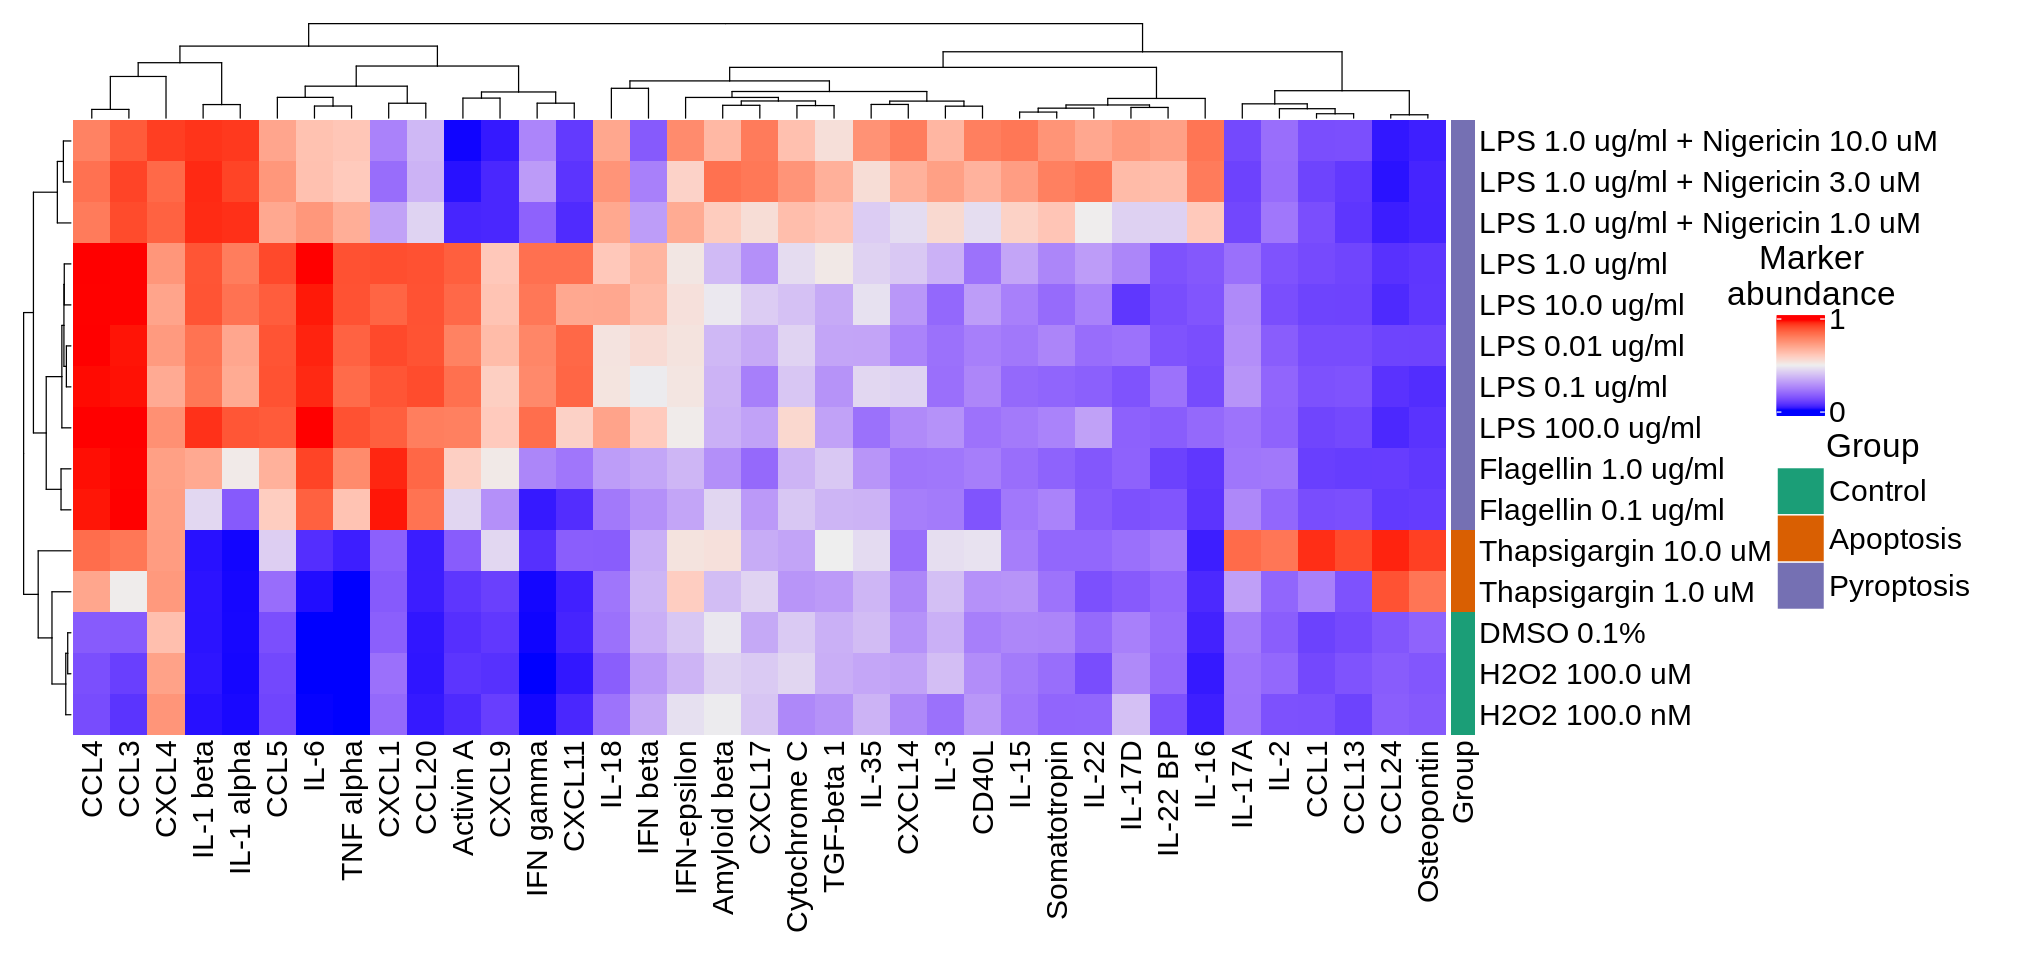

In [45]:
col_func <- colorRampPalette(brewer.pal(9, "Purples"))
# set plot size
width <- 17
height <- 8
options(repr.plot.width=width, repr.plot.height=height, units = "cm")
heatmap_anova_cytokines <- (
    Heatmap(
        (cytokine_values_melted_agg_filtered), 
        cluster_rows = TRUE,    # Cluster rows
        cluster_columns = TRUE, # Cluster columns
        show_row_names = TRUE,  # Show row names
        show_column_names = TRUE, # Show column names
        column_names_gp = gpar(fontsize = 18, fontfamily = "sans"), # Column name label formatting
        row_names_gp = gpar(fontsize = 18, fontfamily = "sans"),    # Row name label formatting
        right_annotation = row_ha,
        # make the tiles rectangular
        rect_gp = gpar(col = NA),
        heatmap_legend_param = list(
                title = "Marker\nabundance", at = c(0, 1), 
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 20), 
                labels_gp = gpar(fontsize = 18),
                direction = "vertical",
                padding = unit(c(10, 10, 5, 5), "mm"),
                grid_width = unit(10, "mm"),
                grid_height = unit(800, "mm")
                ),
        column_dend_height = unit(2, "cm"), 
        row_dend_width = unit(1, "cm")
    )
)
# heatmap_anova_cytokines 
heatmap <- draw(
    heatmap_anova_cytokines, 
    heatmap_legend_side = "right", 
    annotation_legend_side = "right",
    # change locaiton of the legend
    merge_legend = TRUE,
    padding = unit(c(5, 5, 5, 15), "mm"),
)
# save the heatmap as png using device
png(file.path("../figures","selected_cytokines_heatmap.png"), width = width, height = height, units = "in", res = 600)
# make path if it does not exist
dir.create(file.path("../figures"), showWarnings = FALSE)
heatmap
dev.off()


rastergrob[GRID.rastergrob.1647] 

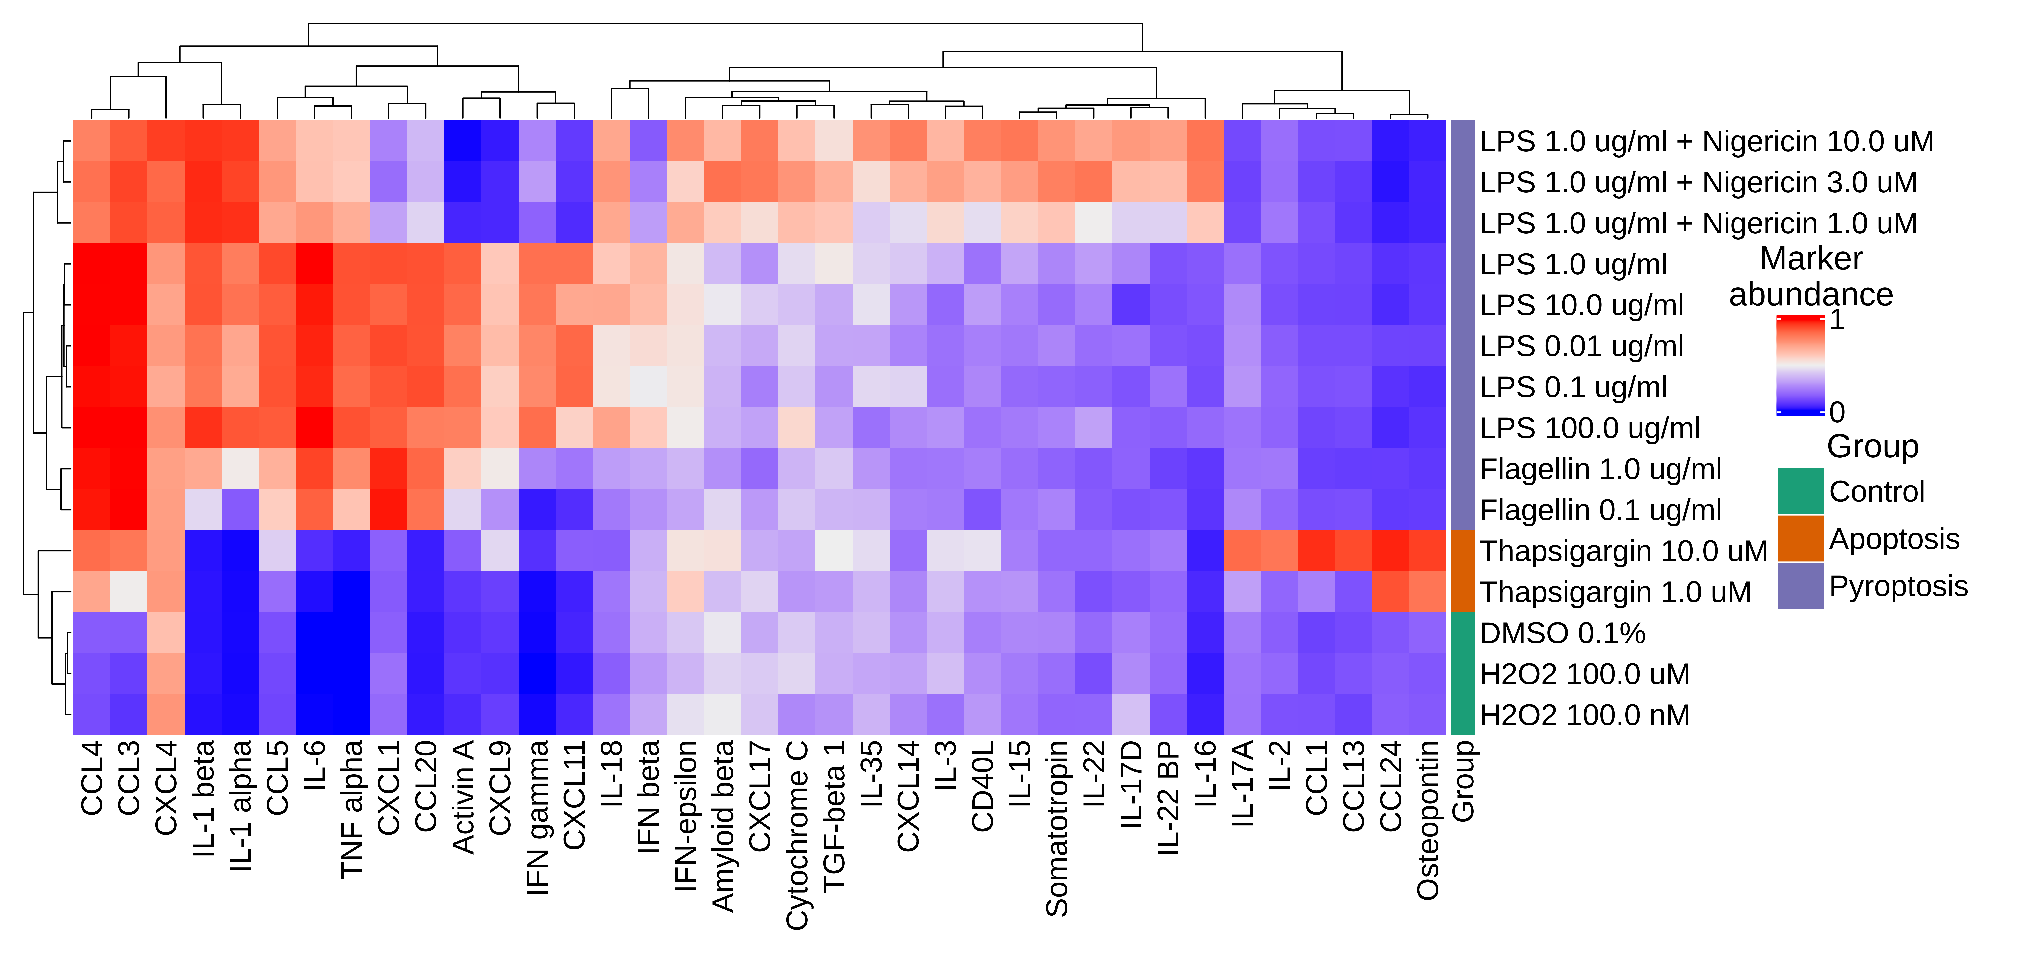

In [46]:
# load in the png to a grob object
heatmap_grob <- png::readPNG(file.path("../figures","selected_cytokines_heatmap.png"))
# convert the grob object to a raster grob
# heatmap_anova_cytokines <- rasterGrob(heatmap_grob, interpolate = TRUE, height = unit(1, "npc"), width = unit(1, "npc"))
heatmap_anova_cytokines <- rasterGrob(heatmap_grob, interpolate = TRUE)

# heatmap_anova_cytokines
heatmap_anova_cytokines
# # Defien the heatmap as a ggplot heatmap for figure curation
# set plot size
width <- 17
height <- 8
options(repr.plot.width=width, repr.plot.height=height, units = "cm")
heatmap_anova_cytokines <- as.ggplot(heatmap_anova_cytokines) 
heatmap_anova_cytokines


## UMAP Plots

In [47]:
# read in the UMAP results
umap_results_path <- file.path("..","..","..","2.Nomic_nELISA_Analysis/1.umap/PBMC/results/nELISA_plate_430420_umap_PBMC.csv")
# read in the data
umap_results <- read.csv(umap_results_path, header = TRUE, sep = ",")


umap_results_selected_treatments_path <- file.path("..","..","..","2.Nomic_nELISA_Analysis/1.umap/PBMC/results/nELISA_plate_430420_umap_PBMC_selected_treatments.csv")
# read in the data
umap_results_selected_treatments <- read.csv(umap_results_selected_treatments_path, header = TRUE, sep = ",")


In [48]:
umap_results_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(umap_results_selected_treatments$oneb_Treatment_Dose_Inhibitor_Dose, levels = list_of_treatments)
# umap_results$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(umap_results$oneb_Treatment_Dose_Inhibitor_Dose, levels = list_of_treatments)


In [49]:
# mutate the names of each treatment
umap_results_selected_treatments <- umap_results_selected_treatments %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))


In [50]:
umap_results <- umap_results %>%
    mutate(oneb_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))


In [51]:
treatment_order <- c(
    'DMSO 0.1%',
    'Flagellin 0.1 ug/ml',
    'Flagellin 1.0 ug/ml',
    'LPS 0.01 ug/ml',
    'LPS 0.1 ug/ml',
    'LPS 1.0 ug/ml',
    'LPS 10.0 ug/ml',
    'LPS 100.0 ug/ml',
    'LPS 1.0 ug/ml + Nigericin 1.0 uM',
    'LPS 1.0 ug/ml + Nigericin 3.0 uM',
    'LPS 1.0 ug/ml + Nigericin 10.0 uM',
    'H2O2 100.0 nM',
    'H2O2 100.0 uM',
    'Thapsigargin 1.0 uM',
    'Thapsigargin 10.0 uM'
)
umap_results_selected_treatments$oneb_Treatment_Dose_Inhibitor_Dose <- factor(umap_results_selected_treatments$oneb_Treatment_Dose_Inhibitor_Dose, levels = treatment_order)


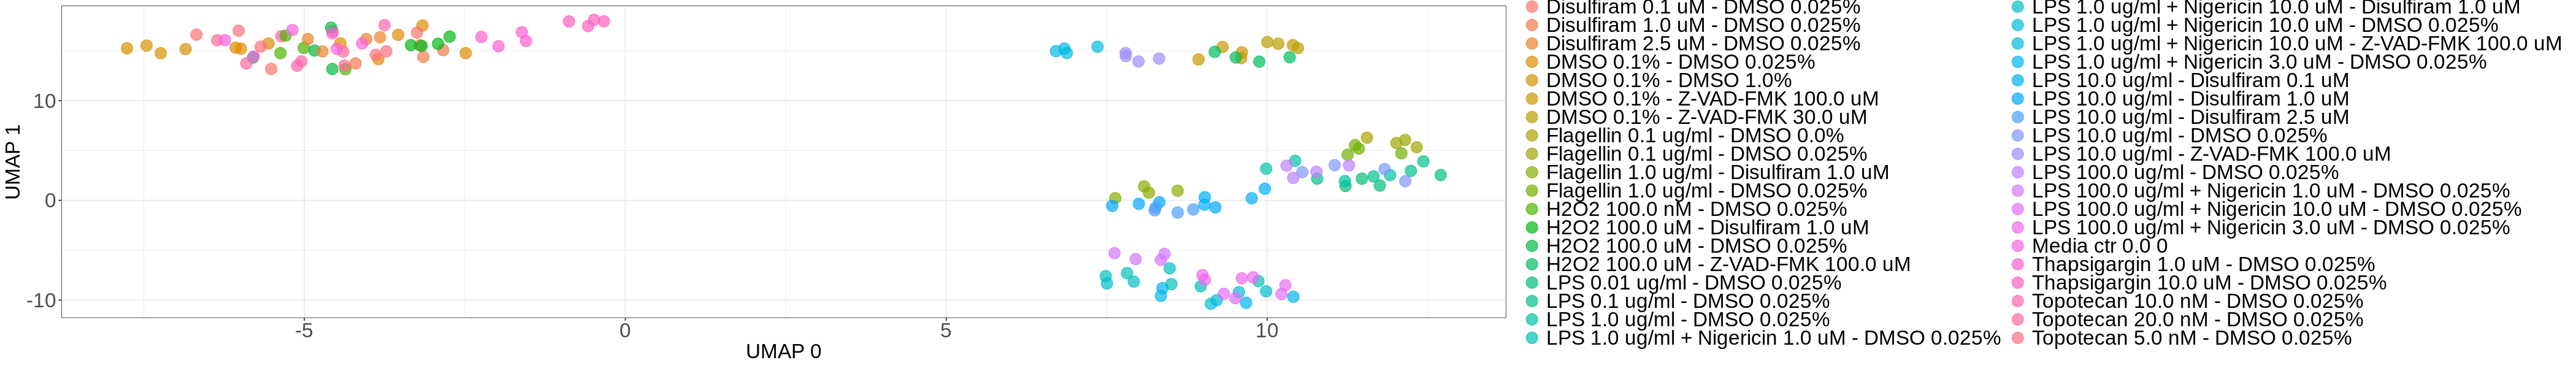

In [52]:
# set the plot size 
options(repr.plot.width=35, repr.plot.height=5)
# plot the umap results
umap_plot_all_treatments <- (
    ggplot(
        data = umap_results,
        aes(
            x = umap_1,
            y = umap_2,
            color = oneb_Treatment_Dose_Inhibitor_Dose
        )
    
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
    + xlab("UMAP 0")
    + ylab("UMAP 1")
    
)
umap_plot_all_treatments

## Selected Treatments

In [53]:
# make a new column that is the treatment group based on the ground truth data
umap_results_selected_treatments$group <- ifelse(umap_results_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(umap_results_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(umap_results_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
umap_results_selected_treatments$group <- factor(umap_results_selected_treatments$group, levels = c("Control","Apoptosis", "Pyroptosis"))
unique(umap_results_selected_treatments$group)

[1] Control    Pyroptosis Apoptosis 
Levels: Control Apoptosis Pyroptosis

In [54]:
# create grouping of treatment and group
umap_results_selected_treatments$group_treatment <- paste(
    umap_results_selected_treatments$oneb_Treatment_Dose_Inhibitor_Dose, 
    umap_results_selected_treatments$group,  
    sep = ", "
    )
# make the group_treatment column a factor
umap_results_selected_treatments$oneb_Treatment_Dose_Inhibitor_Dose <- factor(
    umap_results_selected_treatments$oneb_Treatment_Dose_Inhibitor_Dose, 
    levels = c(
        'DMSO 0.1%',
        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',
        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',
        'H2O2 100.0 nM',
        'H2O2 100.0 uM',
        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM'
    )
)

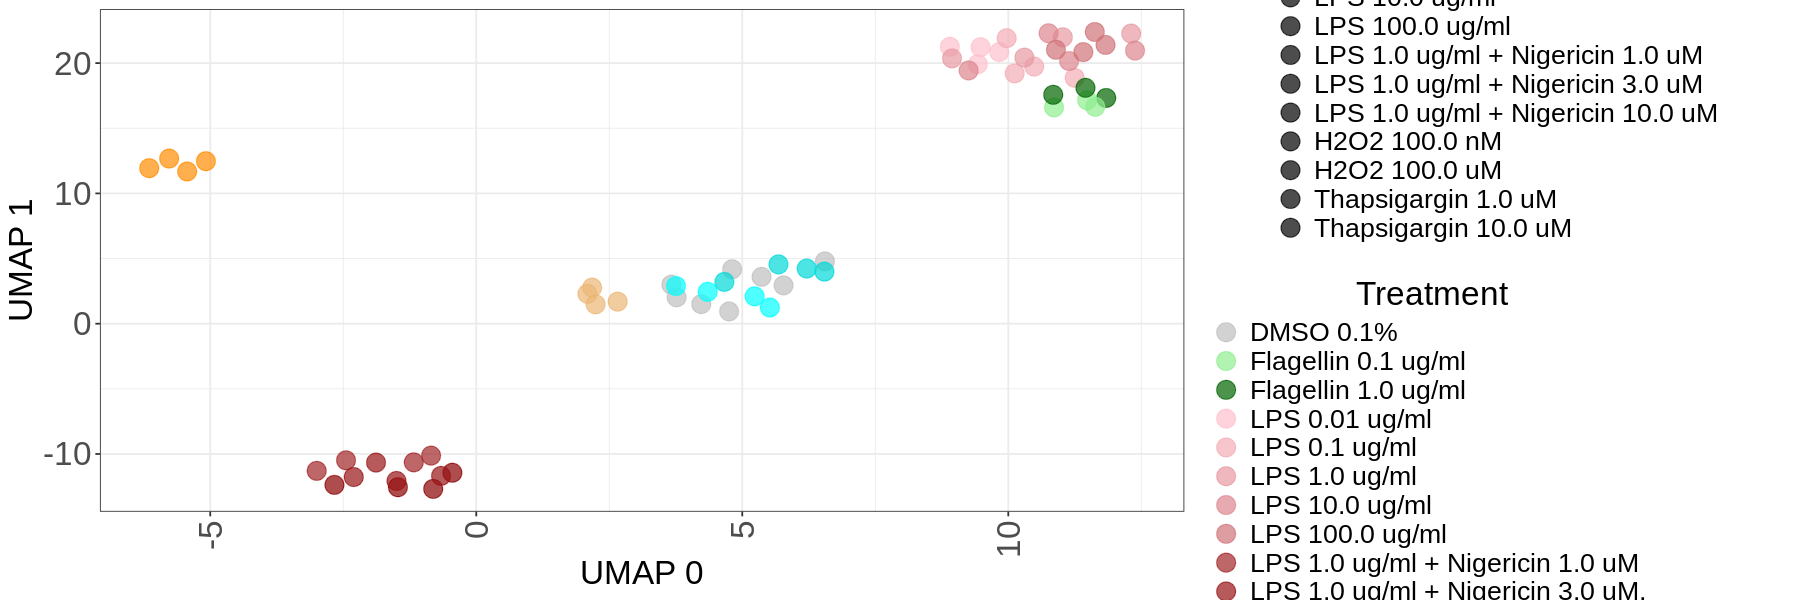

In [55]:
# set the plot size 
options(repr.plot.width=15, repr.plot.height=5)
# plot the umap results
umap_plot_selected_treatments <- (
    ggplot(
        data = umap_results_selected_treatments,
        aes(
            x = umap_1,
            y = umap_2,
            color = oneb_Treatment_Dose_Inhibitor_Dose,
            fill = oneb_Treatment_Dose_Inhibitor_Dose
        )
    )
    + geom_point(size = 5, alpha = 0.7)
    + theme_bw()
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
    + xlab("UMAP 0")
    + ylab("UMAP 1")
    + figure_theme
        + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%',
        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',
        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM,',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',
        'H2O2 100.0 nM',
        'H2O2 100.0 uM',
        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM'
        ),
        values = colors_3)
    )
umap_plot_selected_treatments
# remove the legend
umap_plot_selected_treatments <- umap_plot_selected_treatments + theme(legend.position = "none")


## Patch the plots  together 

In [56]:
# show the plots first as assigned names
# set plot size 
options(repr.plot.width=5, repr.plot.height=5)


In [57]:
# add padding to the bar plot
cytokine_bar_plot <- cytokine_bar_plot + theme(plot.margin = unit(c(2,0,0,0), "cm"))
# add padding to scatter plot
cytokine_scatter_plot <- cytokine_scatter_plot + theme(plot.margin = unit(c(1,0,0,0), "cm"))

png 
  2

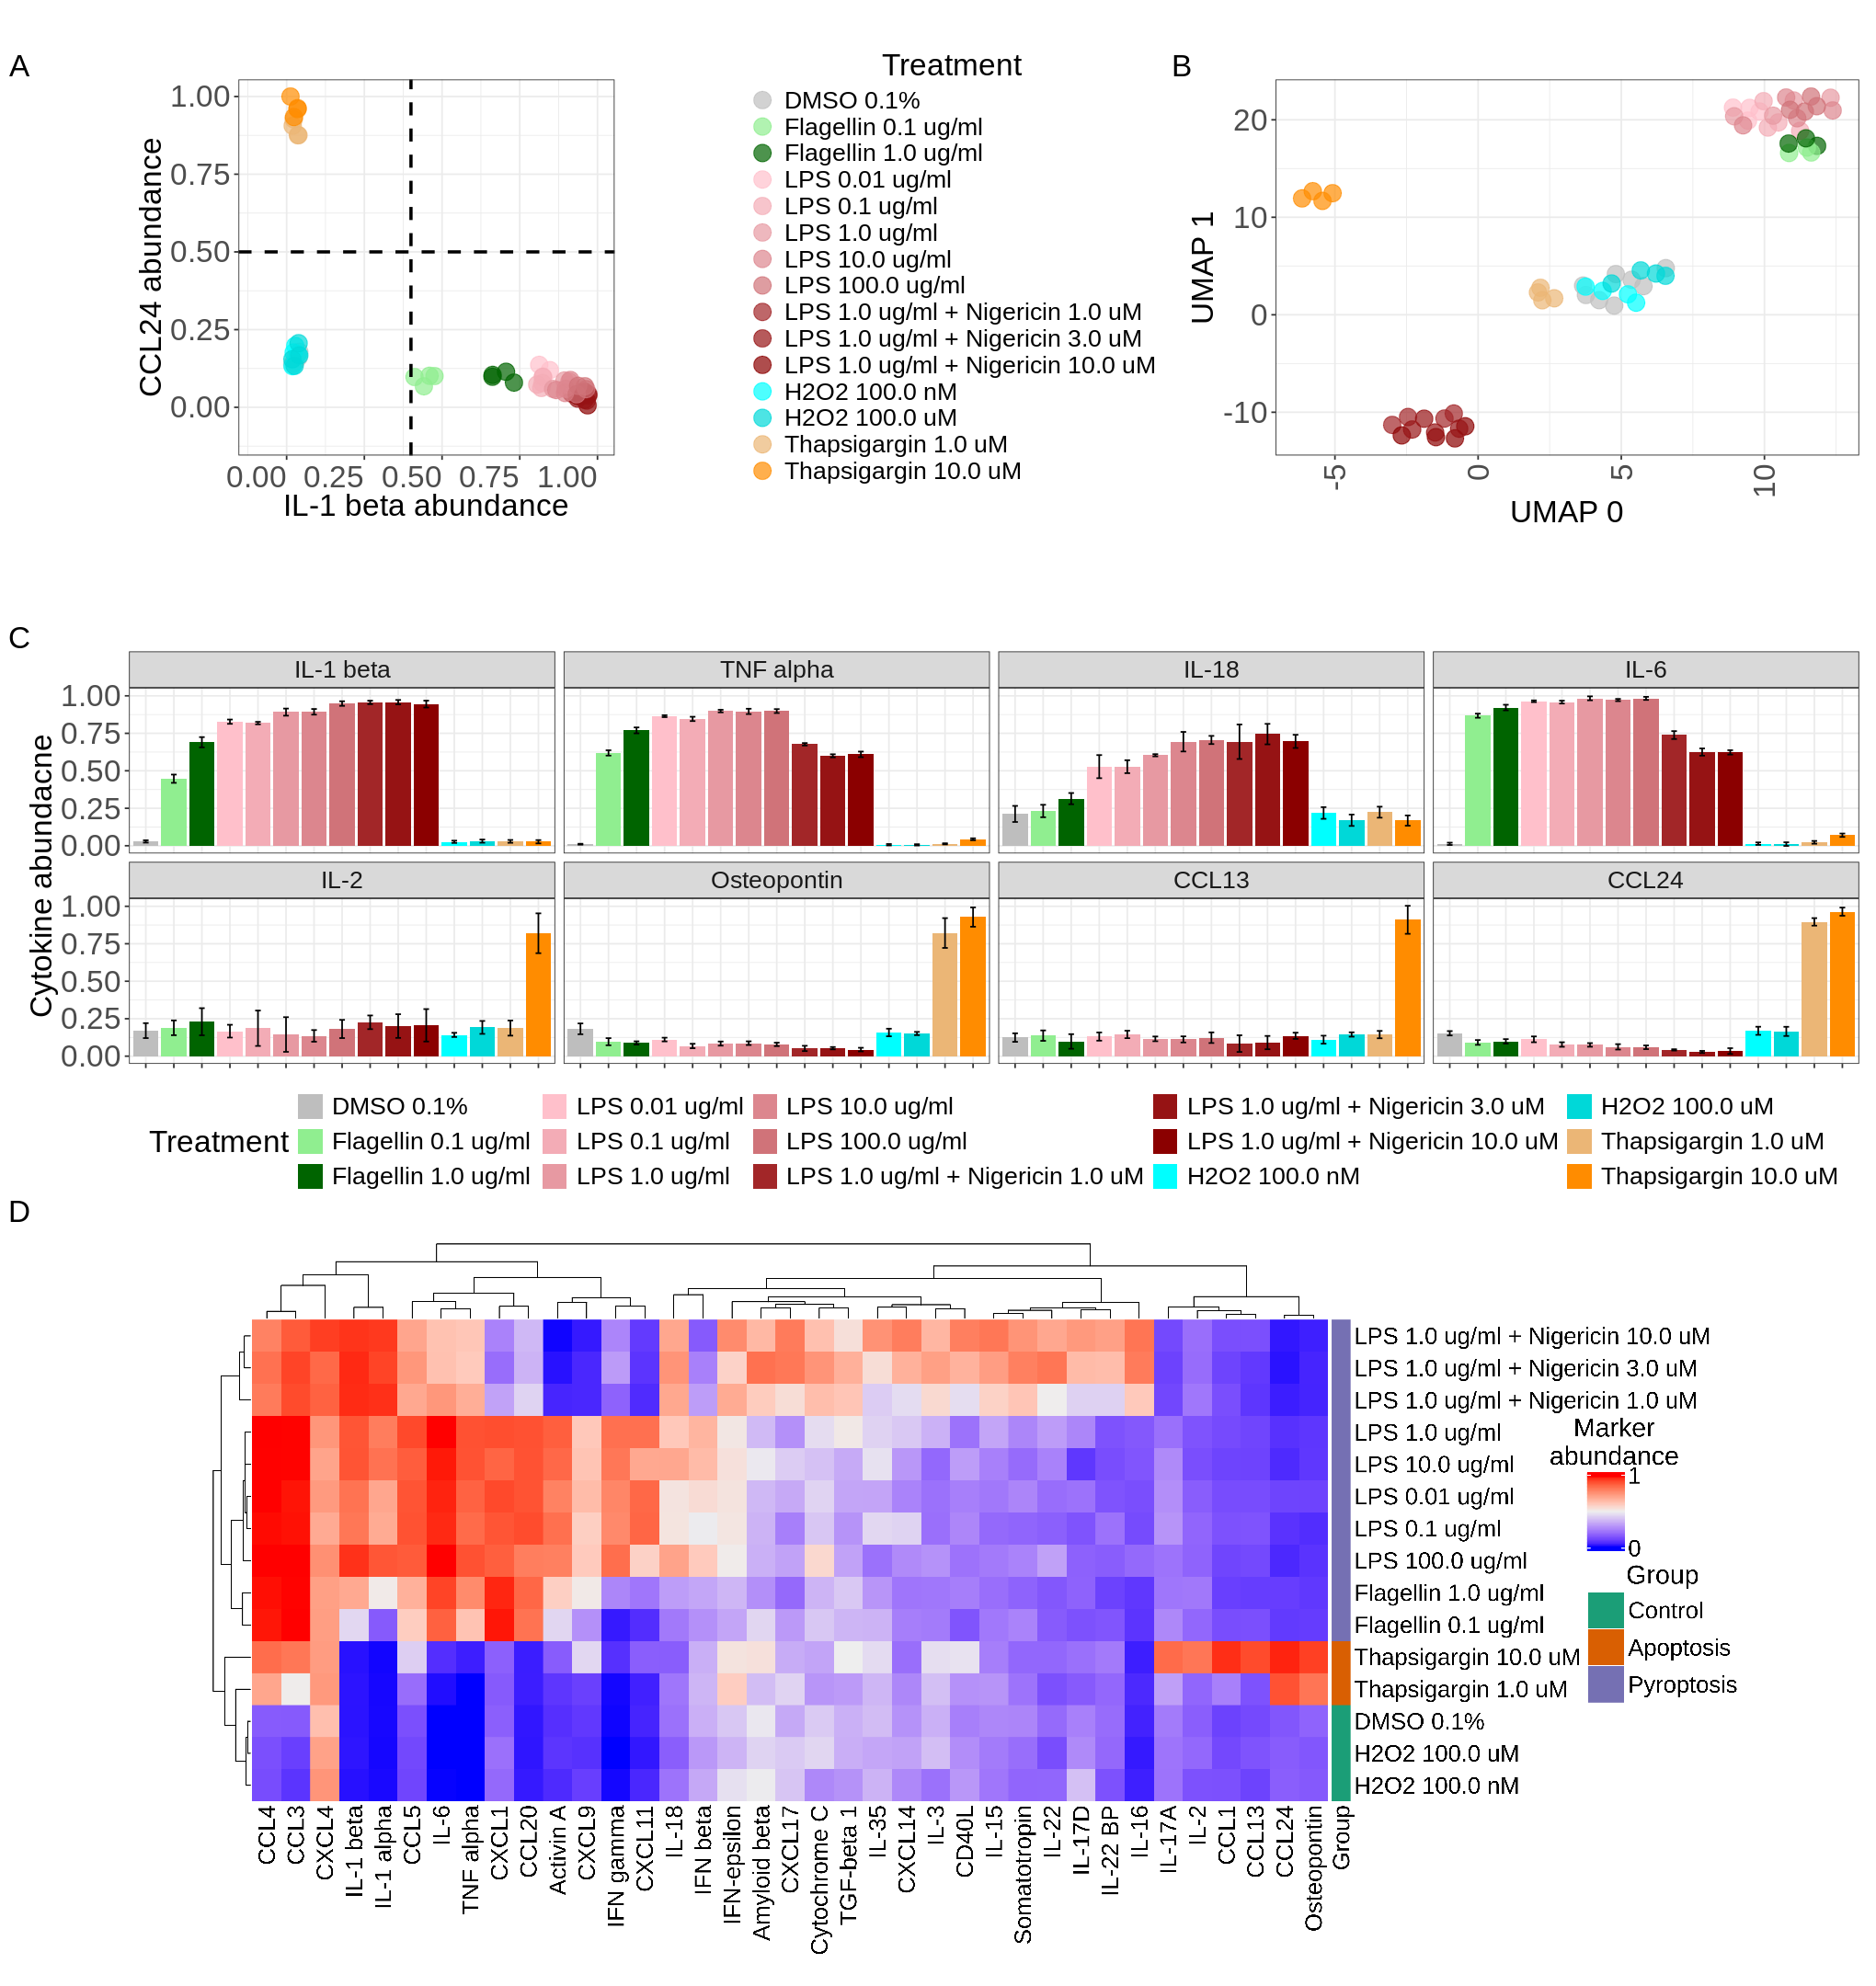

In [58]:
# set the design of the plots in the figure
# Where each letter represents a plot by order defined and the # represents a blank space
# each row represents a proportion of the total plot size
# some plots may be on multiple rows or columns
# plots can be proportioned by adding more letters to the row or column


layout <- c(
    area(t=1, b=2, l=0, r=3), # A
    area(t=1, b=2, l=4, r=5), # B
    area(t=3, b=4, l=0, r=5), # C
    area(t=5, b=8, l=0, r=5) # D
)


# set plot size
width <- 17
height <- 18
options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 600)
fig2 <- (
    cytokine_scatter_plot
    + umap_plot_selected_treatments
    # + wrap_elements(full = umap_plot_selected_treatments)
    # + cytokine_bar_plot 
    + cytokine_bar_plot
    # + new_heatmap
    # + wrap_elements(full = heatmap_anova_cytokines)
    + heatmap_anova_cytokines
    + plot_layout(design = layout, widths = c(0.3,15), heights = c())
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)
# save the figure as png using device
png(file.path("../figures","figure2.png"), width = width, height = height, units = "in", res = 600)
fig2
dev.off()
fig2